### Experiment 1 Desert Rock summary:
1. import bird model ghi values
2. import actual data
3. merge the two based on the common timestamps
4. drop all rows if 'ghi' value is 0
5. Drop all rows with dw_solar < 0
6. Manage missing values: Drop any row if it has -9999.9
7. Make Kt column ('dw_solar'/'ghi') 
8. Group the data into hourly format (by finding mean)
9. assign hierarchical index
10. get the subdataframes for each day and shift the Kt values
11. drop the year, month, day, hour and minute columns
12. feed the data into RNN alrogithm
    - RNN seq_lenth = 1
    - learning rate = 0.001
    - single RNN layer
    - num of epochs = 1000

** in this experiment we are not giving Kt as one of the features. We are using hierarchical index to make sub dataframe for every day and then shift the Kt values one cell up to make it as one hour forecast. **

### NOTE
** the test['Kt'].max() values after grouping into hourly data is 7279.907547 = this is a outlier. The reason might be having a dw_solar reading with QC=2 value. Still haven't checked that. But the second highest value of 'Kt' parameter in the testset is 672 (which is way lower) **

In [1]:
import numpy as np
import pandas as pd
import datetime
import glob
import os.path
from pandas.compat import StringIO

### NREL Bird Model implementation: for obtaining clear sky GHI

In [2]:
import itertools
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [3]:
%matplotlib inline
sns.set_color_codes()

In [4]:
import pvlib
from pvlib import clearsky, atmosphere
from pvlib.location import Location

In [5]:
drk = Location(36.621,-116.043, 'US/Pacific', 1010.1072, 'Desert Rock')

In [6]:
times2009 = pd.DatetimeIndex(start='2009-01-01', end='2010-01-01', freq='1min',
                        tz=drk.tz)   # 12 months of 2009 - For testing
times2010and2011 = pd.DatetimeIndex(start='2010-01-01', end='2012-01-01', freq='1min',
                        tz=drk.tz)   # 24 months of 2010 and 2011 - For training

In [7]:
cs_2009 = drk.get_clearsky(times2009) 
cs_2010and2011 = drk.get_clearsky(times2010and2011) # ineichen with climatology table by default
#cs_2011 = bvl.get_clearsky(times2011) 

In [8]:
cs_2009.drop(['dni','dhi'],axis=1, inplace=True) #updating the same dataframe by dropping two columns
cs_2010and2011.drop(['dni','dhi'],axis=1, inplace=True) #updating the same dataframe by dropping two columns
#cs_2011.drop(['dni','dhi'],axis=1, inplace=True) #updating the same dataframe by dropping two columns

In [9]:
cs_2009.reset_index(inplace=True)
cs_2010and2011.reset_index(inplace=True)
#cs_2011.reset_index(inplace=True)

In [10]:
cs_2009['index']=cs_2009['index'].apply(lambda x:x.to_datetime())
cs_2009['year'] = cs_2009['index'].apply(lambda x:x.year)
cs_2009['month'] = cs_2009['index'].apply(lambda x:x.month)
cs_2009['day'] = cs_2009['index'].apply(lambda x:x.day)
cs_2009['hour'] = cs_2009['index'].apply(lambda x:x.hour)
cs_2009['min'] = cs_2009['index'].apply(lambda x:x.minute)

In [11]:
cs_2010and2011['index']=cs_2010and2011['index'].apply(lambda x:x.to_datetime())
cs_2010and2011['year'] = cs_2010and2011['index'].apply(lambda x:x.year)
cs_2010and2011['month'] = cs_2010and2011['index'].apply(lambda x:x.month)
cs_2010and2011['day'] = cs_2010and2011['index'].apply(lambda x:x.day)
cs_2010and2011['hour'] = cs_2010and2011['index'].apply(lambda x:x.hour)
cs_2010and2011['min'] = cs_2010and2011['index'].apply(lambda x:x.minute)

In [12]:
print(cs_2009.shape)
print(cs_2010and2011.shape)
#print(cs_2011.shape)

(525601, 7)
(1051201, 7)


In [13]:
cs_2009.drop(cs_2009.index[-1], inplace=True)
cs_2010and2011.drop(cs_2010and2011.index[-1], inplace=True)
#cs_2011.drop(cs_2011.index[-1], inplace=True)

In [14]:
print(cs_2009.shape)
print(cs_2010and2011.shape)
#print(cs_2011.shape)

(525600, 7)
(1051200, 7)


In [15]:
cs_2010and2011.head()

,index,ghi,year,month,day,hour,min
0,2010-01-01 00:00:00-08:00,0.0,2010,1,1,0,0
1,2010-01-01 00:01:00-08:00,0.0,2010,1,1,0,1
2,2010-01-01 00:02:00-08:00,0.0,2010,1,1,0,2
3,2010-01-01 00:03:00-08:00,0.0,2010,1,1,0,3
4,2010-01-01 00:04:00-08:00,0.0,2010,1,1,0,4


### Import files from each year in a separate dataframe


- year            integer	 year, i.e., 1995
- jday            integer	 Julian day (1 through 365 [or 366])
- month           integer	 number of the month (1-12)
- day             integer	 day of the month(1-31)
- hour            integer	 hour of the day (0-23)
- min             integer	 minute of the hour (0-59)
- dt              real	 decimal time (hour.decimalminutes, e.g., 23.5 = 2330)
- zen             real	 solar zenith angle (degrees)
- dw_solar        real	 downwelling global solar (Watts m^-2)
- uw_solar        real	 upwelling global solar (Watts m^-2)
- direct_n        real	 direct-normal solar (Watts m^-2)
- diffuse         real	 downwelling diffuse solar (Watts m^-2)
- dw_ir           real	 downwelling thermal infrared (Watts m^-2)
- dw_casetemp     real	 downwelling IR case temp. (K)
- dw_dometemp     real	 downwelling IR dome temp. (K)
- uw_ir           real	 upwelling thermal infrared (Watts m^-2)
- uw_casetemp     real	 upwelling IR case temp. (K)
- uw_dometemp     real	 upwelling IR dome temp. (K)
- uvb             real	 global UVB (milliWatts m^-2)
- par             real	 photosynthetically active radiation (Watts m^-2)
- netsolar        real	 net solar (dw_solar - uw_solar) (Watts m^-2)
- netir           real	 net infrared (dw_ir - uw_ir) (Watts m^-2)
- totalnet        real	 net radiation (netsolar+netir) (Watts m^-2)
- temp            real	 10-meter air temperature (?C)
- rh              real	 relative humidity (%)
- windspd         real	 wind speed (ms^-1)
- winddir         real	 wind direction (degrees, clockwise from north)
- pressure        real	 station pressure (mb)


In [16]:
cols = ['year', 'jday', 'month', 'day','hour','min','dt','zen','dw_solar','dw_solar_QC','uw_solar',
       'uw_solar_QC', 'direct_n','direct_n_QC','diffuse', 'diffuse_QC', 'dw_ir', 'dw_ir_QC', 'dw_casetemp',
       'dw_casetemp_QC', 'dw_dometemp','dw_dometemp_QC','uw_ir', 'uw_ir_QC', 'uw_casetemp','uw_casetemp_QC',
       'uw_dometemp','uw_dometemp_QC','uvb','uvb_QC','par','par_QC','netsolar','netsolar_QC','netir','netir_QC',
       'totalnet','totalnet_QC','temp','temp_QC','rh','rh_QC','windspd','windspd_QC','winddir','winddir_QC',
       'pressure','pressure_QC']

In [17]:
path = r'.\\data\\Desert_Rock\\Exp_1_train'
all_files = glob.glob(path + "/*.dat")
all_files.sort()

df_big_train = pd.concat([pd.read_csv(f, skipinitialspace = True, quotechar = '"',skiprows=(2),delimiter=' ', 
                 index_col=False,header=None, names=cols) for f in all_files],ignore_index=True)
df_big_train.shape

(1047761, 48)

In [18]:
path = r'.\\data\\Desert_Rock\\Exp_1_test'
all_files = glob.glob(path + "/*.dat")
all_files.sort()

df_big_test = pd.concat((pd.read_csv(f, skipinitialspace = True, quotechar = '"',skiprows=(2),delimiter=' ', 
                 index_col=False,header=None, names=cols) for f in all_files),ignore_index=True)
df_big_test.shape

(525542, 48)

In [19]:
df_big_test[df_big_test['dw_solar']==-9999.9].shape

(11338, 48)

### Merging Clear Sky GHI And the big dataframe

In [20]:
df_train = pd.merge(df_big_train, cs_2010and2011, on=['year','month','day','hour','min'])
df_train.shape

(1047761, 50)

In [21]:
df_test = pd.merge(df_big_test, cs_2009, on=['year','month','day','hour','min'])
df_test.shape

(525542, 50)

In [22]:
df_train.drop(['index'],axis=1, inplace=True) #updating the same dataframe by dropping the index columns from clear sky model
df_test.drop(['index'], axis=1, inplace=True)

In [23]:
df_train.shape

(1047761, 49)

### Managing missing values

In [24]:
# Resetting index
df_train.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

In [25]:
# Dropping rows with two or more -9999.9 values in columns

In [26]:
# Step1: Get indices of all rows with 2 or more -999
missing_data_indices = np.where((df_train <=-9999.9).apply(sum, axis=1)>=2)[0]
# Step2: Drop those indices
df_train.drop(missing_data_indices, axis=0, inplace=True)
# Checking that the rows are dropped
df_train.shape

(988587, 49)

In [27]:
missing_data_indices_test = np.where((df_test <= -9999.9).apply(sum, axis=1)>=2)[0]
df_test.drop(missing_data_indices_test, axis=0, inplace=True)
df_test.shape

(524158, 49)

In [28]:
# For the rows with only one cell as -9999.9, replacing this cell with the mean of the column

#### First resetting index after dropping rows in the previous part of the code

In [29]:
# 2nd time - Reseting Index
df_train.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

In [30]:
one_miss_train_idx = np.where((df_train <=-9999.9).apply(sum, axis=1)==1)[0]

In [31]:
len(one_miss_train_idx)

16067

In [32]:
df_train.shape

(988587, 49)

In [33]:
col_names = df_train.columns
from collections import defaultdict
stats = defaultdict(int)
total_single_missing_values = 0
for name in col_names:
    col_mean = df_train[~(df_train[name] == -9999.9)][name].mean()
    missing_indices = np.where((df_train[name] == -9999.9))
    stats[name] = len(missing_indices[0])
    df_train[name].loc[missing_indices] = col_mean
    total_single_missing_values += sum(df_train[name] == -9999.9)
    

C:\Users\s269596\AppData\Local\Continuum\Anaconda3\lib\site-packages\pandas\core\indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [34]:
#df_col_min = df_train.apply(min, axis=0)
#df_col_max = df_train.apply(max, axis =0)
#print(df_col_min, df_col_max)

In [35]:
train = np.where((df_train <=-9999.9).apply(sum, axis=1)==1)[0]

In [36]:
len(train)

0

In [37]:
# doing the same thing on test dataset

In [38]:
one_miss_test_idx = np.where((df_test <=-9999.9).apply(sum, axis=1)==1)[0]
len(one_miss_test_idx)

10590

In [39]:
col_names_test = df_test.columns
from collections import defaultdict
stats_test = defaultdict(int)
total_single_missing_values_test = 0
for name in col_names_test:
    col_mean = df_test[~(df_test[name] == -9999.9)][name].mean()
    missing_indices = np.where((df_test[name] == -9999.9))
    stats_test[name] = len(missing_indices[0])
    df_test[name].loc[missing_indices] = col_mean
    total_single_missing_values_test += sum(df_test[name] == -9999.9)
    

C:\Users\s269596\AppData\Local\Continuum\Anaconda3\lib\site-packages\pandas\core\indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [40]:
test = np.where((df_test <=-9999.9).apply(sum, axis=1)==1)[0]

In [41]:
len(test)

0

In [42]:
df_train.shape

(988587, 49)

In [43]:
df_test.shape

(524158, 49)

### Exploratory Data Analysis

In [44]:
dw_solar_everyday = df_test.groupby(['jday'])['dw_solar'].mean()
ghi_everyday = df_test.groupby(['jday'])['ghi'].mean()
j_day = df_test['jday'].unique()

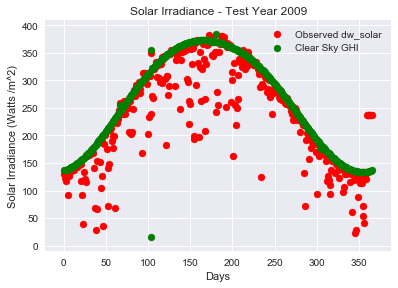

In [45]:
fig = plt.figure()

axes1 = fig.add_axes([0.1,0.1,0.8,0.8])
#axes2 = fig.add_axes([0.1,0.1,0.8,0.8])

axes1.scatter(j_day,dw_solar_everyday,label='Observed dw_solar',color='red')
axes1.scatter(j_day, ghi_everyday, label='Clear Sky GHI',color='green')

axes1.set_xlabel('Days')
axes1.set_ylabel('Solar Irradiance (Watts /m^2)')
axes1.set_title('Solar Irradiance - Test Year 2009')
axes1.legend(loc='best')

fig.savefig('Figure3.png', bbox_inches = 'tight')

C:\Users\s269596\AppData\Local\Continuum\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


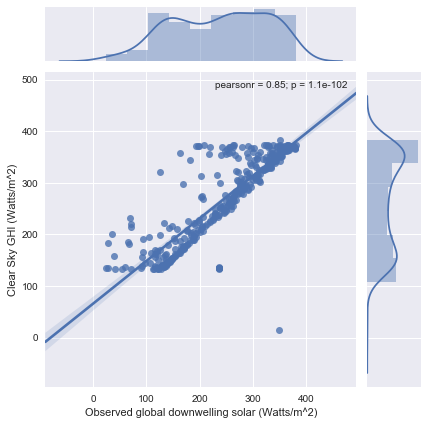

In [46]:
sns.jointplot(x=dw_solar_everyday,y=ghi_everyday,kind='reg')
#plt.title('observed dw_solar vs clear sky ghi')
plt.xlabel('Observed global downwelling solar (Watts/m^2)')
plt.ylabel('Clear Sky GHI (Watts/m^2)')
plt.savefig('Figure3.png', bbox_inches='tight')

### making the Kt (clear sky index at time t) column by first removing rows with ghi==0

In [47]:
df_train = df_train[df_train['ghi']!=0]
df_test = df_test[df_test['ghi']!=0]
df_train['Kt'] = df_train['dw_solar']/df_train['ghi']
df_test['Kt'] = df_test['dw_solar']/df_test['ghi']

In [48]:
df_train.reset_index(inplace=True)
df_test.reset_index(inplace=True)

In [49]:
print("test Kt max: "+str(df_test['Kt'].max()))
print("test Kt min: "+str(df_test['Kt'].min()))
print("test Kt mean: "+str(df_test['Kt'].mean()))
print("\n")
print("train Kt max: "+str(df_train['Kt'].max()))
print("train Kt min: "+str(df_train['Kt'].min()))
print("train Kt mean: "+str(df_train['Kt'].mean()))

test Kt max: 934060.7967236277
test Kt min: -1212.4523861041143
test Kt mean: 6.087694158417696


train Kt max: 36737.73884840597
train Kt min: -404.8538655568123
train Kt mean: 2.4557778502312537


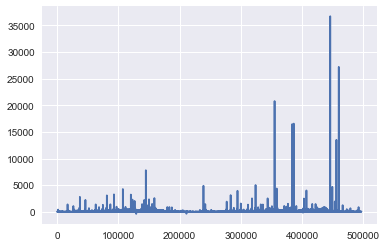

In [50]:
plt.plot(df_train['Kt'])

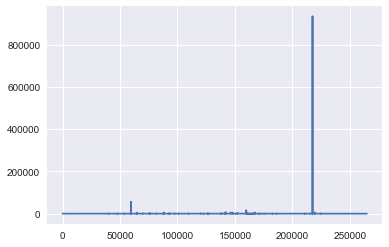

In [51]:
plt.plot(df_test['Kt'])

In [52]:
df_train= df_train[df_train['Kt']< 5000]
df_train= df_train[df_train['Kt']> -1000]
df_test= df_test[df_test['Kt']< 5000]
df_test= df_test[df_test['Kt']> -1000]

#### Group the data (train dataframe)

In [53]:
zen = df_train.groupby(['year','month','day','hour'])['zen'].mean()
dw_solar = df_train.groupby(['year','month','day','hour'])['dw_solar'].mean()
uw_solar = df_train.groupby(['year','month','day','hour'])['uw_solar'].mean()
direct_n = df_train.groupby(['year','month','day','hour'])['direct_n'].mean()
diffuse = df_train.groupby(['year','month','day','hour'])['diffuse'].mean()
dw_ir = df_train.groupby(['year','month','day','hour'])['dw_ir'].mean()
dw_casetemp = df_train.groupby(['year','month','day','hour'])['dw_casetemp'].mean()
dw_dometemp = df_train.groupby(['year','month','day','hour'])['dw_dometemp'].mean()
uw_ir = df_train.groupby(['year','month','day','hour'])['uw_ir'].mean()
uw_casetemp = df_train.groupby(['year','month','day','hour'])['uw_casetemp'].mean()
uw_dometemp = df_train.groupby(['year','month','day','hour'])['uw_dometemp'].mean()
uvb = df_train.groupby(['year','month','day','hour'])['uvb'].mean()
par = df_train.groupby(['year','month','day','hour'])['par'].mean()
netsolar = df_train.groupby(['year','month','day','hour'])['netsolar'].mean()
netir = df_train.groupby(['year','month','day','hour'])['netir'].mean()
totalnet = df_train.groupby(['year','month','day','hour'])['totalnet'].mean()
temp = df_train.groupby(['year','month','day','hour'])['temp'].mean()
rh = df_train.groupby(['year','month','day','hour'])['rh'].mean()
windspd = df_train.groupby(['year','month','day','hour'])['windspd'].mean()
winddir = df_train.groupby(['year','month','day','hour'])['winddir'].mean()
pressure = df_train.groupby(['year','month','day','hour'])['pressure'].mean()
ghi = df_train.groupby(['year','month','day','hour'])['ghi'].mean()
Kt = df_train.groupby(['year','month','day','hour'])['Kt'].mean()

In [54]:
df_new_train = pd.concat([zen,dw_solar,uw_solar,direct_n,diffuse,dw_ir,dw_casetemp,dw_dometemp,uw_ir,uw_casetemp,uw_dometemp,
                    uvb,par,netsolar,netir,totalnet,temp,rh,windspd,winddir,pressure,ghi,Kt], axis=1)

In [55]:
df_new_train.head()

zen    dw_solar  uw_solar  direct_n   diffuse  \
year   month day hour                                                         
2010.0 1.0   1.0 6.0   162.750000  229.275124 -1.300000  1.800000 -0.700000   
                 7.0   165.356667  229.275124 -1.366667  1.018333 -0.885000   
                 8.0   163.399000  229.275124 -1.450000  0.781667 -0.781667   
                 9.0   154.172667  229.275124 -1.561667  0.983333 -0.815000   
                 10.0  142.737000  229.275124 -1.428333  1.516667 -0.661667   

                            dw_ir  dw_casetemp  dw_dometemp       uw_ir  \
year   month day hour                                                     
2010.0 1.0   1.0 6.0   243.300000   276.200000   275.700000  308.800000   
                 7.0   241.946667   275.456667   274.983333  307.460000   
                 8.0   244.203333   275.143333   274.721667  304.498333   
                 9.0   245.158333   274.786667   274.335000  303.886667   
                 10.0  256.343333   274.830000   274.453333  305.071667   

                       uw_casetemp    ...      netsolar      netir   totalnet  \
year   month day hour                 ...                                       
2010.0 1.0   1.0 6.0    274.700000    ...           0.0 -65.500000 -65.500000   
                 7.0    274.423333    ...           0.0 -65.521667 -65.521667   
                 8.0    273.966667    ...           0.0 -60.288333 -60.288333   
                 9.0    273.730000    ...           0.0 -58.726667 -58.726667   
                 10.0   273.793333    ...           0.0 -48.730000 -48.730000   

                           temp         rh   windspd     winddir    pressure  \
year   month day hour                                                          
2010.0 1.0   1.0 6.0   3.600000  39.000000  1.000000   56.400000  915.400000   
                 7.0   2.268333  41.808333  2.255000  115.338333  915.410000   
                 8.0   1.918333  43.545000  0.883333  167.170000  915.458333   
                 9.0   2.043333  43.063333  1.690000  130.491667  915.133333   
                 10.0  1.671667  44.681667  1.256667  104.535000  915.161667   

                              ghi         Kt  
year   month day hour                         
2010.0 1.0   1.0 6.0     8.485002  27.021223  
                 7.0    72.956955   4.371045  
                 8.0   234.169751   1.026259  
                 9.0   388.224711   0.596671  
                 10.0  496.624772   0.462711  

[5 rows x 23 columns]

#### Groupdata - test dataframe

In [56]:
test_zen = df_test.groupby(['month','day','hour'])['zen'].mean()
test_dw_solar = df_test.groupby(['month','day','hour'])['dw_solar'].mean()
test_uw_solar = df_test.groupby(['month','day','hour'])['uw_solar'].mean()
test_direct_n = df_test.groupby(['month','day','hour'])['direct_n'].mean()
test_diffuse = df_test.groupby(['month','day','hour'])['diffuse'].mean()
test_dw_ir = df_test.groupby(['month','day','hour'])['dw_ir'].mean()
test_dw_casetemp = df_test.groupby(['month','day','hour'])['dw_casetemp'].mean()
test_dw_dometemp = df_test.groupby(['month','day','hour'])['dw_dometemp'].mean()
test_uw_ir = df_test.groupby(['month','day','hour'])['uw_ir'].mean()
test_uw_casetemp = df_test.groupby(['month','day','hour'])['uw_casetemp'].mean()
test_uw_dometemp = df_test.groupby(['month','day','hour'])['uw_dometemp'].mean()
test_uvb = df_test.groupby(['month','day','hour'])['uvb'].mean()
test_par = df_test.groupby(['month','day','hour'])['par'].mean()
test_netsolar = df_test.groupby(['month','day','hour'])['netsolar'].mean()
test_netir = df_test.groupby(['month','day','hour'])['netir'].mean()
test_totalnet = df_test.groupby(['month','day','hour'])['totalnet'].mean()
test_temp = df_test.groupby(['month','day','hour'])['temp'].mean()
test_rh = df_test.groupby(['month','day','hour'])['rh'].mean()
test_windspd = df_test.groupby(['month','day','hour'])['windspd'].mean()
test_winddir = df_test.groupby(['month','day','hour'])['winddir'].mean()
test_pressure = df_test.groupby(['month','day','hour'])['pressure'].mean()
test_ghi = df_test.groupby(['month','day','hour'])['ghi'].mean()
test_Kt = df_test.groupby(['month','day','hour'])['Kt'].mean()

In [57]:
df_new_test = pd.concat([test_zen,test_dw_solar,test_uw_solar,test_direct_n,test_diffuse,test_dw_ir,
                         test_dw_casetemp,test_dw_dometemp,test_uw_ir,test_uw_casetemp,test_uw_dometemp,
                    test_uvb,test_par,test_netsolar,test_netir,test_totalnet,test_temp,test_rh,
                         test_windspd,test_winddir,test_pressure,test_ghi,test_Kt], axis=1)

In [58]:
df_new_test.loc[2].xs(17,level='day')

,zen,dw_solar,uw_solar,direct_n,diffuse,dw_ir,dw_casetemp,dw_dometemp,uw_ir,uw_casetemp,...,netsolar,netir,totalnet,temp,rh,windspd,winddir,pressure,ghi,Kt
hour,,,,,,,,,,,,,,,,,,,,,
6.0,150.286429,-5.457143,4.758099e-17,-0.175000,-0.053571,238.189286,280.017857,279.328571,327.503571,278.535714,...,0.000000,-89.325000,-89.325000,5.610714,61.664286,10.210714,198.364286,895.860714,33.869158,-0.199644
7.0,154.152333,-5.783333,-3.450000e-01,0.123333,-0.021667,238.683333,279.945000,279.300000,327.176667,278.526667,...,0.000000,-88.500000,-88.500000,5.720000,59.485000,9.733333,198.575000,896.445000,156.492998,-0.043188
8.0,154.031833,-5.948333,-2.000000e-01,-0.068333,0.016667,234.365000,279.816667,279.126667,325.691667,278.390000,...,0.000000,-91.336667,-91.336667,5.523333,57.200000,9.743333,206.088333,897.225000,358.157279,-0.016985
9.0,147.761500,-6.048333,-2.966667e-01,0.083333,0.048333,234.465000,279.631667,278.981667,324.173333,278.226667,...,0.000000,-89.698333,-89.698333,5.428333,54.283333,7.906667,204.571667,898.161667,534.190398,-0.011397
10.0,137.994833,-6.270000,-2.583333e-01,0.140000,0.168333,233.670000,279.040000,278.473333,321.188333,277.590000,...,0.000000,-87.516667,-87.516667,4.856667,58.343333,4.830000,221.958333,898.420000,660.519935,-0.009504
11.0,126.708167,-6.398333,-4.233333e-01,0.073333,0.118333,232.613333,278.768333,278.190000,318.916667,277.463333,...,0.000000,-86.303333,-86.303333,4.821667,56.403333,3.730000,242.768333,898.488333,725.681709,-0.008817
12.0,114.824167,-6.381667,-4.466667e-01,0.233333,0.161667,231.091667,277.991667,277.468333,317.415000,276.856667,...,0.000000,-86.321667,-86.321667,4.230000,57.873333,4.493333,240.988333,898.961667,724.381774,-0.008812
13.0,102.804000,-6.466667,-3.716667e-01,0.581667,0.128333,231.006667,277.816667,277.293333,317.900000,276.565000,...,0.000000,-86.886667,-86.886667,3.931667,59.148333,4.121667,251.095000,899.751667,656.728953,-0.009876
14.0,90.783167,4.851667,2.676667e+00,113.013333,7.931667,232.438333,278.385000,277.873333,319.696667,276.965000,...,11.883333,-87.261667,-75.386667,4.480000,54.673333,4.691667,230.323333,900.423333,528.243267,0.011476


### Shifting Kt values to make 1 hour ahead forecast

#### Train dataset

In [59]:
levels_index= []
for m in df_new_train.index.levels:
    levels_index.append(m)

In [60]:
for i in levels_index[0]:
    for j in levels_index[1]:
        df_new_train.loc[i].loc[j]['Kt'] = df_new_train.loc[i].loc[j]['Kt'].shift(-1)

In [61]:
df_new_train = df_new_train[~(df_new_train['Kt'].isnull())]

#### Test dataset

In [62]:
levels_index2= []
for m in df_new_test.index.levels:
    levels_index2.append(m)

In [63]:
for i in levels_index2[0]:
    for j in levels_index2[1]:
        df_new_test.loc[i].loc[j]['Kt'] = df_new_test.loc[i].loc[j]['Kt'].shift(-1)

In [64]:
df_new_test = df_new_test[~(df_new_test['Kt'].isnull())]

In [65]:
df_new_test[df_new_test['Kt']==df_new_test['Kt'].max()]

,,,zen,dw_solar,uw_solar,direct_n,diffuse,dw_ir,dw_casetemp,dw_dometemp,uw_ir,uw_casetemp,...,netsolar,netir,totalnet,temp,rh,windspd,winddir,pressure,ghi,Kt
month,day,hour,,,,,,,,,,,,,,,,,,,,,
7.0,16.0,19.0,16.453833,1036.853333,207.88,937.083333,94.176667,392.505,316.651667,315.851667,654.351667,313.416667,...,784.853333,-261.845,523.001667,37.598333,11.703333,5.456667,240.191667,903.088333,56.199403,4900.219009


### Normalize train and test dataframe

In [66]:
train_norm = (df_new_train - df_new_train.mean()) / (df_new_train.max() - df_new_train.min())
test_norm =  (df_new_test - df_new_test.mean()) / (df_new_test.max() - df_new_test.min())

In [67]:
train_norm.reset_index(inplace=True,drop=True)
test_norm.reset_index(inplace=True,drop=True)

### Making train and test sets with train_norm and test_norm

#### finding the gcf (greatest common factor) of train and test dataset's length and chop off the extra rows to make it divisible with the batchsize

In [68]:
from fractions import gcd
gcd(train_norm.shape[0],test_norm.shape[0])

C:\Users\s269596\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: fractions.gcd() is deprecated. Use math.gcd() instead.
  


2

In [69]:
import math
def roundup(x):
    return int(math.ceil(x / 100.0)) * 100

In [70]:
train_lim = roundup(train_norm.shape[0])
test_lim = roundup(test_norm.shape[0])

train_random = train_norm.sample(train_lim-train_norm.shape[0])
test_random = test_norm.sample(test_lim-test_norm.shape[0])

train_norm = train_norm.append(train_random)
test_norm = test_norm.append(test_random)

In [71]:
X1 = train_norm.drop('Kt',axis=1)
y1 = train_norm['Kt']

X2 = test_norm.drop('Kt',axis=1)
y2 = test_norm['Kt']

In [72]:
print("X1_train shape is {}".format(X1.shape))
print("y1_train shape is {}".format(y1.shape))
print("X2_test shape is {}".format(X2.shape))
print("y2_test shape is {}".format(y2.shape))

X1_train shape is (9000, 22)
y1_train shape is (9000,)
X2_test shape is (4500, 22)
y2_test shape is (4500,)


In [73]:
X_train = np.array(X1)
y_train  = np.array(y1)
X_test = np.array(X2)
y_test = np.array(y2)

### start of RNN

In [74]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch.autograd import Variable

In [75]:
class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(RNNModel, self).__init__()
        #Hidden Dimension
        self.hidden_dim = hidden_dim
        
        # Number of hidden layers
        self.layer_dim = layer_dim
        
        #Building the RNN
        self.rnn = nn.RNN(input_dim, hidden_dim, layer_dim, batch_first=True, nonlinearity='relu')
        
        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        # Initializing the hidden state with zeros
        # (layer_dim, batch_size, hidden_dim)
        h0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim))
        
        #One time step (the last one perhaps?)
        out, hn = self.rnn(x, h0)
        
        # Indexing hidden state of the last time step
        # out.size() --> ??
        #out[:,-1,:] --> is it going to be 100,100
        out = self.fc(out[:,-1,:])
        # out.size() --> 100,1
        return out
        

In [76]:
# Instantiating Model Class
input_dim = 22
hidden_dim = 15
layer_dim = 1
output_dim = 1
batch_size = 100

model = RNNModel(input_dim, hidden_dim, layer_dim, output_dim)

# Instantiating Loss Class
criterion = nn.MSELoss()

# Instantiate Optimizer Class
learning_rate = 0.001
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# converting numpy array to torch tensor
X_train = torch.from_numpy(X_train)
y_train = torch.from_numpy(y_train)
X_test = torch.from_numpy(X_test)
y_test = torch.from_numpy(y_test)

# initializing lists to store losses over epochs:
train_loss = []
test_loss = []
train_iter = []
test_iter = []

In [77]:
# Training the model
seq_dim = 1

n_iter =0
num_samples = len(X_train)
test_samples = len(X_test)
batch_size = 100
num_epochs = 5000
feat_dim = X_train.shape[1]

X_train = X_train.type(torch.FloatTensor)
y_train = y_train.type(torch.FloatTensor)
X_test = X_test.type(torch.FloatTensor)
y_test = y_test.type(torch.FloatTensor)

for epoch in range(num_epochs):
    for i in range(0, int(num_samples/batch_size -1)):
        
        
        features = Variable(X_train[i*batch_size:(i+1)*batch_size, :]).view(-1, seq_dim, feat_dim)
        Kt_value = Variable(y_train[i*batch_size:(i+1)*batch_size])
        
        #print("Kt_value={}".format(Kt_value))
        
        optimizer.zero_grad()
        
        outputs = model(features)
        #print("outputs ={}".format(outputs))
        
        loss = criterion(outputs, Kt_value)
        
        train_loss.append(loss.data[0])
        train_iter.append(n_iter)

        #print("loss = {}".format(loss))
        loss.backward()
        
        optimizer.step()
        
        n_iter += 1  
            
        if n_iter%100 == 0:
            for i in range(0,int(test_samples/batch_size -1)):
                features = Variable(X_test[i*batch_size:(i+1)*batch_size, :]).view(-1, seq_dim, feat_dim)
                Kt_test = Variable(y_test[i*batch_size:(i+1)*batch_size])
                
                outputs = model(features)
                
                mse = np.sqrt(np.mean((Kt_test.data.numpy() - outputs.data.numpy().squeeze())**2)/num_samples)
                
                test_iter.append(n_iter)
                test_loss.append(mse)
                
            print('Epoch: {} Iteration: {}. Train_MSE: {}. Test_MSE: {}'.format(epoch, n_iter, loss.data[0], mse))
               

Epoch: 1 Iteration: 100. Train_MSE: 0.004700318910181522. Test_MSE: 0.00019951935628665442
Epoch: 2 Iteration: 200. Train_MSE: 0.012488487176597118. Test_MSE: 0.0002042209739458771
Epoch: 3 Iteration: 300. Train_MSE: 0.0015307371504604816. Test_MSE: 0.00024397069262226752
Epoch: 4 Iteration: 400. Train_MSE: 0.0006486308411695063. Test_MSE: 0.0002769354265236081
Epoch: 5 Iteration: 500. Train_MSE: 0.003521236125379801. Test_MSE: 0.00030508233865041465
Epoch: 6 Iteration: 600. Train_MSE: 0.003108575940132141. Test_MSE: 0.00033278958745323574
Epoch: 7 Iteration: 700. Train_MSE: 0.0023963607382029295. Test_MSE: 0.00035171668768771983
Epoch: 8 Iteration: 800. Train_MSE: 0.0009026312036439776. Test_MSE: 0.00035802223106929423
Epoch: 10 Iteration: 900. Train_MSE: 0.0014665904454886913. Test_MSE: 0.0003586035647292295
Epoch: 11 Iteration: 1000. Train_MSE: 0.00286492588929832. Test_MSE: 0.00036656470342391937
Epoch: 12 Iteration: 1100. Train_MSE: 0.00044321443419903517. Test_MSE: 0.000369560184

Epoch: 99 Iteration: 8900. Train_MSE: 0.00047664064913988113. Test_MSE: 0.00022064910122448017
Epoch: 101 Iteration: 9000. Train_MSE: 0.0009640545467846096. Test_MSE: 0.0002193198664067997
Epoch: 102 Iteration: 9100. Train_MSE: 0.011478479020297527. Test_MSE: 0.00022051205019290102
Epoch: 103 Iteration: 9200. Train_MSE: 0.000360287434887141. Test_MSE: 0.0002192498705292263
Epoch: 104 Iteration: 9300. Train_MSE: 0.0005225582281127572. Test_MSE: 0.00021739197039148073
Epoch: 105 Iteration: 9400. Train_MSE: 0.0008762446814216673. Test_MSE: 0.00021702176732094042
Epoch: 106 Iteration: 9500. Train_MSE: 0.0009848945774137974. Test_MSE: 0.00021847813239134998
Epoch: 107 Iteration: 9600. Train_MSE: 0.001845917897298932. Test_MSE: 0.0002177839070551418
Epoch: 108 Iteration: 9700. Train_MSE: 0.000474257831228897. Test_MSE: 0.00021622469988754394
Epoch: 110 Iteration: 9800. Train_MSE: 0.0005140160210430622. Test_MSE: 0.000214622588730169
Epoch: 111 Iteration: 9900. Train_MSE: 0.000620234000962227

Epoch: 197 Iteration: 17600. Train_MSE: 0.0006676554912701249. Test_MSE: 0.00018780169578305926
Epoch: 198 Iteration: 17700. Train_MSE: 0.0003821039863396436. Test_MSE: 0.00018715685609422937
Epoch: 199 Iteration: 17800. Train_MSE: 0.0003515480784699321. Test_MSE: 0.00018589597272462453
Epoch: 201 Iteration: 17900. Train_MSE: 0.0008445049170404673. Test_MSE: 0.00018507085460115808
Epoch: 202 Iteration: 18000. Train_MSE: 0.011552000418305397. Test_MSE: 0.0001863040067472395
Epoch: 203 Iteration: 18100. Train_MSE: 0.00028837850550189614. Test_MSE: 0.00018526255737888266
Epoch: 204 Iteration: 18200. Train_MSE: 0.0004111622693017125. Test_MSE: 0.00018402670539868646
Epoch: 205 Iteration: 18300. Train_MSE: 0.0007362404721789062. Test_MSE: 0.0001840211700641069
Epoch: 206 Iteration: 18400. Train_MSE: 0.0009726168937049806. Test_MSE: 0.00018549279420315332
Epoch: 207 Iteration: 18500. Train_MSE: 0.0018363134004175663. Test_MSE: 0.0001849015590683355
Epoch: 208 Iteration: 18600. Train_MSE: 0.0

Epoch: 294 Iteration: 26200. Train_MSE: 0.0010165736312046647. Test_MSE: 0.0001653994257739018
Epoch: 295 Iteration: 26300. Train_MSE: 0.0005173470708541572. Test_MSE: 0.00016421306087957896
Epoch: 296 Iteration: 26400. Train_MSE: 0.0004986481508240104. Test_MSE: 0.00016471715748503452
Epoch: 297 Iteration: 26500. Train_MSE: 0.0006269895238801837. Test_MSE: 0.00016607184252982483
Epoch: 298 Iteration: 26600. Train_MSE: 0.000332206254824996. Test_MSE: 0.00016545965208751798
Epoch: 299 Iteration: 26700. Train_MSE: 0.00027694969321601093. Test_MSE: 0.00016436715099787488
Epoch: 301 Iteration: 26800. Train_MSE: 0.0007644108845852315. Test_MSE: 0.00016362296966622504
Epoch: 302 Iteration: 26900. Train_MSE: 0.011541861109435558. Test_MSE: 0.00016484555106424567
Epoch: 303 Iteration: 27000. Train_MSE: 0.00024121880414895713. Test_MSE: 0.00016389202090590023
Epoch: 304 Iteration: 27100. Train_MSE: 0.000344157888321206. Test_MSE: 0.00016281615733297538
Epoch: 305 Iteration: 27200. Train_MSE: 0.

Epoch: 391 Iteration: 34800. Train_MSE: 0.0005174034740775824. Test_MSE: 0.0001492153130054209
Epoch: 392 Iteration: 34900. Train_MSE: 0.0006343390559777617. Test_MSE: 0.00014888975136660463
Epoch: 393 Iteration: 35000. Train_MSE: 0.004801211878657341. Test_MSE: 0.00014986126666019498
Epoch: 394 Iteration: 35100. Train_MSE: 0.0009764244896359742. Test_MSE: 0.00014891137121139596
Epoch: 395 Iteration: 35200. Train_MSE: 0.0004103840619791299. Test_MSE: 0.0001478497901466207
Epoch: 396 Iteration: 35300. Train_MSE: 0.0004510217404458672. Test_MSE: 0.00014836419227952548
Epoch: 397 Iteration: 35400. Train_MSE: 0.0005976631655357778. Test_MSE: 0.0001497238736619344
Epoch: 398 Iteration: 35500. Train_MSE: 0.00029474409529939294. Test_MSE: 0.0001491409765946912
Epoch: 399 Iteration: 35600. Train_MSE: 0.00022546781110577285. Test_MSE: 0.0001481628559835846
Epoch: 401 Iteration: 35700. Train_MSE: 0.0007051195134408772. Test_MSE: 0.00014746597012506678
Epoch: 402 Iteration: 35800. Train_MSE: 0.01

Epoch: 487 Iteration: 43400. Train_MSE: 0.0005800285143777728. Test_MSE: 0.00013683043707184598
Epoch: 488 Iteration: 43500. Train_MSE: 0.002147187013179064. Test_MSE: 0.0001377749916124864
Epoch: 489 Iteration: 43600. Train_MSE: 0.0001230055495398119. Test_MSE: 0.00013736289397431778
Epoch: 491 Iteration: 43700. Train_MSE: 0.0004649501934181899. Test_MSE: 0.00013624565690441382
Epoch: 492 Iteration: 43800. Train_MSE: 0.0005882836412638426. Test_MSE: 0.00013593671312316034
Epoch: 493 Iteration: 43900. Train_MSE: 0.004795147571712732. Test_MSE: 0.0001368887457993497
Epoch: 494 Iteration: 44000. Train_MSE: 0.0009473407990299165. Test_MSE: 0.00013599795525399462
Epoch: 495 Iteration: 44100. Train_MSE: 0.000333282514475286. Test_MSE: 0.00013502874043685068
Epoch: 496 Iteration: 44200. Train_MSE: 0.00041511625749990344. Test_MSE: 0.00013553879385795915
Epoch: 497 Iteration: 44300. Train_MSE: 0.0005762730725109577. Test_MSE: 0.00013689444479308632
Epoch: 498 Iteration: 44400. Train_MSE: 0.00

Epoch: 584 Iteration: 52000. Train_MSE: 0.0009997703600674868. Test_MSE: 0.00012752480278092703
Epoch: 585 Iteration: 52100. Train_MSE: 0.0002543587179388851. Test_MSE: 0.0001266138638610548
Epoch: 586 Iteration: 52200. Train_MSE: 0.0002580114814918488. Test_MSE: 0.00012576158811797726
Epoch: 587 Iteration: 52300. Train_MSE: 0.00055885617621243. Test_MSE: 0.000126587158637371
Epoch: 588 Iteration: 52400. Train_MSE: 0.002107167150825262. Test_MSE: 0.000127512598716107
Epoch: 589 Iteration: 52500. Train_MSE: 0.00011391092266421765. Test_MSE: 0.0001271453216658946
Epoch: 591 Iteration: 52600. Train_MSE: 0.00042541182483546436. Test_MSE: 0.00012610243314276813
Epoch: 592 Iteration: 52700. Train_MSE: 0.0005528486799448729. Test_MSE: 0.00012580831998155293
Epoch: 593 Iteration: 52800. Train_MSE: 0.0047915359027683735. Test_MSE: 0.00012673899430558241
Epoch: 594 Iteration: 52900. Train_MSE: 0.0009259373182430863. Test_MSE: 0.00012590438359744247
Epoch: 595 Iteration: 53000. Train_MSE: 0.00027

Epoch: 680 Iteration: 60600. Train_MSE: 0.00014705030480399728. Test_MSE: 0.00011954280399460226
Epoch: 682 Iteration: 60700. Train_MSE: 0.00010970574658131227. Test_MSE: 0.00011840248558380535
Epoch: 683 Iteration: 60800. Train_MSE: 0.000310791889205575. Test_MSE: 0.00011835244019312996
Epoch: 684 Iteration: 60900. Train_MSE: 0.0009851986542344093. Test_MSE: 0.00011911478662461335
Epoch: 685 Iteration: 61000. Train_MSE: 0.0002343375381315127. Test_MSE: 0.00011824734976810911
Epoch: 686 Iteration: 61100. Train_MSE: 0.00022596921189688146. Test_MSE: 0.00011746388312386157
Epoch: 687 Iteration: 61200. Train_MSE: 0.0005410797311924398. Test_MSE: 0.00011826461156171286
Epoch: 688 Iteration: 61300. Train_MSE: 0.0020745322108268738. Test_MSE: 0.00011916446436427979
Epoch: 689 Iteration: 61400. Train_MSE: 0.00010710384958656505. Test_MSE: 0.00011883448362162256
Epoch: 691 Iteration: 61500. Train_MSE: 0.00039479066617786884. Test_MSE: 0.00011784694842081878
Epoch: 692 Iteration: 61600. Train_M

Epoch: 778 Iteration: 69300. Train_MSE: 0.0005530595080927014. Test_MSE: 0.00011217787396708516
Epoch: 779 Iteration: 69400. Train_MSE: 0.006985077168792486. Test_MSE: 0.00011257662192048732
Epoch: 780 Iteration: 69500. Train_MSE: 0.00013794608821626753. Test_MSE: 0.00011253416919727974
Epoch: 782 Iteration: 69600. Train_MSE: 9.811289783101529e-05. Test_MSE: 0.00011144942710122392
Epoch: 783 Iteration: 69700. Train_MSE: 0.0002926575834862888. Test_MSE: 0.00011139089838468731
Epoch: 784 Iteration: 69800. Train_MSE: 0.0009725562413223088. Test_MSE: 0.00011213605972197715
Epoch: 785 Iteration: 69900. Train_MSE: 0.00021819741232320666. Test_MSE: 0.00011131168164686285
Epoch: 786 Iteration: 70000. Train_MSE: 0.00020107768068555743. Test_MSE: 0.00011059329028745484
Epoch: 787 Iteration: 70100. Train_MSE: 0.0005246401997283101. Test_MSE: 0.00011136948253481307
Epoch: 788 Iteration: 70200. Train_MSE: 0.0020473396871238947. Test_MSE: 0.00011224589962991641
Epoch: 789 Iteration: 70300. Train_MSE

Epoch: 875 Iteration: 77900. Train_MSE: 0.0008691120310686529. Test_MSE: 0.00010688364152528762
Epoch: 876 Iteration: 78000. Train_MSE: 6.820056296419352e-05. Test_MSE: 0.00010607265181005418
Epoch: 877 Iteration: 78100. Train_MSE: 0.000172174462932162. Test_MSE: 0.0001053701513110968
Epoch: 878 Iteration: 78200. Train_MSE: 0.0005439681117422879. Test_MSE: 0.00010643581509995073
Epoch: 879 Iteration: 78300. Train_MSE: 0.006972985342144966. Test_MSE: 0.00010681125852763915
Epoch: 880 Iteration: 78400. Train_MSE: 0.00013055741146672517. Test_MSE: 0.00010680339040521743
Epoch: 882 Iteration: 78500. Train_MSE: 8.904263086151332e-05. Test_MSE: 0.00010576468215944906
Epoch: 883 Iteration: 78600. Train_MSE: 0.0002779758651740849. Test_MSE: 0.00010569643577047155
Epoch: 884 Iteration: 78700. Train_MSE: 0.0009624502272345126. Test_MSE: 0.00010642018228720534
Epoch: 885 Iteration: 78800. Train_MSE: 0.00020476100326050073. Test_MSE: 0.00010563042604740149
Epoch: 886 Iteration: 78900. Train_MSE: 0

Epoch: 973 Iteration: 86600. Train_MSE: 0.00010109194408869371. Test_MSE: 0.00010134440493267905
Epoch: 974 Iteration: 86700. Train_MSE: 0.0002774743770714849. Test_MSE: 0.00010138539122947752
Epoch: 975 Iteration: 86800. Train_MSE: 0.0008641390595585108. Test_MSE: 0.00010195855568600973
Epoch: 976 Iteration: 86900. Train_MSE: 6.204169039847329e-05. Test_MSE: 0.00010118503173050267
Epoch: 977 Iteration: 87000. Train_MSE: 0.00015245311078615487. Test_MSE: 0.00010053797296993338
Epoch: 978 Iteration: 87100. Train_MSE: 0.00053481973009184. Test_MSE: 0.00010156641319879045
Epoch: 979 Iteration: 87200. Train_MSE: 0.0069625498726964. Test_MSE: 0.00010192096481534212
Epoch: 980 Iteration: 87300. Train_MSE: 0.00012446247274056077. Test_MSE: 0.00010194658600471845
Epoch: 982 Iteration: 87400. Train_MSE: 8.177143172360957e-05. Test_MSE: 0.00010094984475535971
Epoch: 983 Iteration: 87500. Train_MSE: 0.00026615645037963986. Test_MSE: 0.00010087406952069471
Epoch: 984 Iteration: 87600. Train_MSE: 0

Epoch: 1069 Iteration: 95200. Train_MSE: 0.00027970041264779866. Test_MSE: 9.796191186015167e-05
Epoch: 1070 Iteration: 95300. Train_MSE: 0.000193326995940879. Test_MSE: 9.826993837871318e-05
Epoch: 1071 Iteration: 95400. Train_MSE: 0.0001109770018956624. Test_MSE: 9.82103053242278e-05
Epoch: 1073 Iteration: 95500. Train_MSE: 9.597622556611896e-05. Test_MSE: 9.725765418257827e-05
Epoch: 1074 Iteration: 95600. Train_MSE: 0.00026131878257729113. Test_MSE: 9.728019051060908e-05
Epoch: 1075 Iteration: 95700. Train_MSE: 0.0008597595733590424. Test_MSE: 9.783925932125053e-05
Epoch: 1076 Iteration: 95800. Train_MSE: 5.7173481764039025e-05. Test_MSE: 9.709976175666222e-05
Epoch: 1077 Iteration: 95900. Train_MSE: 0.00013697677059099078. Test_MSE: 9.650015477534189e-05
Epoch: 1078 Iteration: 96000. Train_MSE: 0.0005258375313133001. Test_MSE: 9.748798268171155e-05
Epoch: 1079 Iteration: 96100. Train_MSE: 0.006953724194318056. Test_MSE: 9.78201989981301e-05
Epoch: 1080 Iteration: 96200. Train_MSE:

Epoch: 1166 Iteration: 103800. Train_MSE: 0.004357580095529556. Test_MSE: 9.434075321299349e-05
Epoch: 1167 Iteration: 103900. Train_MSE: 9.544602653477341e-05. Test_MSE: 9.37554973669922e-05
Epoch: 1168 Iteration: 104000. Train_MSE: 6.489227234851569e-05. Test_MSE: 9.324439455405297e-05
Epoch: 1169 Iteration: 104100. Train_MSE: 0.0002640610618982464. Test_MSE: 9.429034334773068e-05
Epoch: 1170 Iteration: 104200. Train_MSE: 0.00019592480384744704. Test_MSE: 9.458437401485933e-05
Epoch: 1171 Iteration: 104300. Train_MSE: 0.00010686660243663937. Test_MSE: 9.45513073309594e-05
Epoch: 1173 Iteration: 104400. Train_MSE: 9.140068868873641e-05. Test_MSE: 9.36295752205962e-05
Epoch: 1174 Iteration: 104500. Train_MSE: 0.0002478252863511443. Test_MSE: 9.363358583597563e-05
Epoch: 1175 Iteration: 104600. Train_MSE: 0.0008558685076422989. Test_MSE: 9.417664866334525e-05
Epoch: 1176 Iteration: 104700. Train_MSE: 5.3264568123267964e-05. Test_MSE: 9.346718880073188e-05
Epoch: 1177 Iteration: 104800. 

Epoch: 1262 Iteration: 112400. Train_MSE: 0.001838082098402083. Test_MSE: 9.144407906616597e-05
Epoch: 1264 Iteration: 112500. Train_MSE: 0.00063622638117522. Test_MSE: 9.046465178267534e-05
Epoch: 1265 Iteration: 112600. Train_MSE: 0.00021750880114268512. Test_MSE: 9.072696067970104e-05
Epoch: 1266 Iteration: 112700. Train_MSE: 0.004354275297373533. Test_MSE: 9.101897519689695e-05
Epoch: 1267 Iteration: 112800. Train_MSE: 8.709046232979745e-05. Test_MSE: 9.046721652935135e-05
Epoch: 1268 Iteration: 112900. Train_MSE: 6.162184581626207e-05. Test_MSE: 8.998454531111785e-05
Epoch: 1269 Iteration: 113000. Train_MSE: 0.00025074646691791713. Test_MSE: 9.098980170169874e-05
Epoch: 1270 Iteration: 113100. Train_MSE: 0.00019859118037857115. Test_MSE: 9.127126358878313e-05
Epoch: 1271 Iteration: 113200. Train_MSE: 0.00010336667037336156. Test_MSE: 9.126374764857613e-05
Epoch: 1273 Iteration: 113300. Train_MSE: 8.727330714464188e-05. Test_MSE: 9.037020148191148e-05
Epoch: 1274 Iteration: 113400.

Epoch: 1359 Iteration: 121000. Train_MSE: 6.351872434606776e-05. Test_MSE: 8.732419383516902e-05
Epoch: 1360 Iteration: 121100. Train_MSE: 0.0004966163542121649. Test_MSE: 8.849165856427915e-05
Epoch: 1361 Iteration: 121200. Train_MSE: 0.00022774311946704984. Test_MSE: 8.859372850856915e-05
Epoch: 1362 Iteration: 121300. Train_MSE: 0.0018320322269573808. Test_MSE: 8.846893040935776e-05
Epoch: 1364 Iteration: 121400. Train_MSE: 0.0006242942181415856. Test_MSE: 8.751892520134074e-05
Epoch: 1365 Iteration: 121500. Train_MSE: 0.00021081911108922213. Test_MSE: 8.775583722432232e-05
Epoch: 1366 Iteration: 121600. Train_MSE: 0.004350605886429548. Test_MSE: 8.80368713616179e-05
Epoch: 1367 Iteration: 121700. Train_MSE: 8.002013055374846e-05. Test_MSE: 8.751608006258718e-05
Epoch: 1368 Iteration: 121800. Train_MSE: 5.899597454117611e-05. Test_MSE: 8.706031030734614e-05
Epoch: 1369 Iteration: 121900. Train_MSE: 0.00023925550340209156. Test_MSE: 8.80278578175252e-05
Epoch: 1370 Iteration: 122000.

Epoch: 1456 Iteration: 129600. Train_MSE: 0.0002932428033091128. Test_MSE: 8.545349503973322e-05
Epoch: 1457 Iteration: 129700. Train_MSE: 0.012235191650688648. Test_MSE: 8.522817806521548e-05
Epoch: 1458 Iteration: 129800. Train_MSE: 8.229084050981328e-05. Test_MSE: 8.510312312824182e-05
Epoch: 1459 Iteration: 129900. Train_MSE: 6.0831542214145884e-05. Test_MSE: 8.464265583788385e-05
Epoch: 1460 Iteration: 130000. Train_MSE: 0.00047385902144014835. Test_MSE: 8.576615815874969e-05
Epoch: 1461 Iteration: 130100. Train_MSE: 0.00022347818594425917. Test_MSE: 8.586547994137087e-05
Epoch: 1462 Iteration: 130200. Train_MSE: 0.0018267056439071894. Test_MSE: 8.576175606060816e-05
Epoch: 1464 Iteration: 130300. Train_MSE: 0.0006137244636192918. Test_MSE: 8.483880143654743e-05
Epoch: 1465 Iteration: 130400. Train_MSE: 0.00020511343609541655. Test_MSE: 8.505159632397027e-05
Epoch: 1466 Iteration: 130500. Train_MSE: 0.004348024260252714. Test_MSE: 8.53203471542495e-05
Epoch: 1467 Iteration: 130600

Epoch: 1552 Iteration: 138200. Train_MSE: 0.00018470124632585794. Test_MSE: 8.358449153510064e-05
Epoch: 1553 Iteration: 138300. Train_MSE: 0.006777184549719095. Test_MSE: 8.335677999998805e-05
Epoch: 1555 Iteration: 138400. Train_MSE: 7.913081935839728e-05. Test_MSE: 8.250835887466324e-05
Epoch: 1556 Iteration: 138500. Train_MSE: 0.00028728897450491786. Test_MSE: 8.296065689620259e-05
Epoch: 1557 Iteration: 138600. Train_MSE: 0.01221963856369257. Test_MSE: 8.27334123072175e-05
Epoch: 1558 Iteration: 138700. Train_MSE: 7.8437318734359e-05. Test_MSE: 8.263428331807139e-05
Epoch: 1559 Iteration: 138800. Train_MSE: 5.848504588357173e-05. Test_MSE: 8.219678552667079e-05
Epoch: 1560 Iteration: 138900. Train_MSE: 0.0004538796201813966. Test_MSE: 8.327972821819592e-05
Epoch: 1561 Iteration: 139000. Train_MSE: 0.00022018076560925692. Test_MSE: 8.337856009344141e-05
Epoch: 1562 Iteration: 139100. Train_MSE: 0.0018221106147393584. Test_MSE: 8.329687478939419e-05
Epoch: 1564 Iteration: 139200. Tr

Epoch: 1649 Iteration: 146800. Train_MSE: 7.997483771760017e-05. Test_MSE: 8.059556259690264e-05
Epoch: 1650 Iteration: 146900. Train_MSE: 5.636245623463765e-05. Test_MSE: 8.017631225875378e-05
Epoch: 1651 Iteration: 147000. Train_MSE: 0.00040098626050166786. Test_MSE: 8.138895981144891e-05
Epoch: 1652 Iteration: 147100. Train_MSE: 0.00017960114928428084. Test_MSE: 8.128807942614253e-05
Epoch: 1653 Iteration: 147200. Train_MSE: 0.006773944012820721. Test_MSE: 8.107659706543058e-05
Epoch: 1655 Iteration: 147300. Train_MSE: 7.548181747552007e-05. Test_MSE: 8.025217317420455e-05
Epoch: 1656 Iteration: 147400. Train_MSE: 0.0002820171357598156. Test_MSE: 8.0676741278874e-05
Epoch: 1657 Iteration: 147500. Train_MSE: 0.012202867306768894. Test_MSE: 8.044603234558791e-05
Epoch: 1658 Iteration: 147600. Train_MSE: 7.499565981561318e-05. Test_MSE: 8.036775162224732e-05
Epoch: 1659 Iteration: 147700. Train_MSE: 5.639622759190388e-05. Test_MSE: 7.994895995390116e-05
Epoch: 1660 Iteration: 147800. T

Epoch: 1746 Iteration: 155400. Train_MSE: 0.00013746472541242838. Test_MSE: 7.824361891151216e-05
Epoch: 1747 Iteration: 155500. Train_MSE: 0.00030281185172498226. Test_MSE: 7.88807466008279e-05
Epoch: 1748 Iteration: 155600. Train_MSE: 0.00017859722720459104. Test_MSE: 7.85444864958827e-05
Epoch: 1749 Iteration: 155700. Train_MSE: 7.622189150424674e-05. Test_MSE: 7.846139024042292e-05
Epoch: 1750 Iteration: 155800. Train_MSE: 5.4119205742608756e-05. Test_MSE: 7.806540781065607e-05
Epoch: 1751 Iteration: 155900. Train_MSE: 0.0003926833451259881. Test_MSE: 7.923725044119195e-05
Epoch: 1752 Iteration: 156000. Train_MSE: 0.00017506045696791261. Test_MSE: 7.914207537336207e-05
Epoch: 1753 Iteration: 156100. Train_MSE: 0.006770846899598837. Test_MSE: 7.894668343123505e-05
Epoch: 1755 Iteration: 156200. Train_MSE: 7.213609205791727e-05. Test_MSE: 7.814684318699449e-05
Epoch: 1756 Iteration: 156300. Train_MSE: 0.00027674619923345745. Test_MSE: 7.854614361314335e-05
Epoch: 1757 Iteration: 1564

Epoch: 1842 Iteration: 164000. Train_MSE: 0.0002796541666612029. Test_MSE: 7.75692631382039e-05
Epoch: 1843 Iteration: 164100. Train_MSE: 0.00020183893502689898. Test_MSE: 7.740830818318724e-05
Epoch: 1844 Iteration: 164200. Train_MSE: 4.0919989260146394e-05. Test_MSE: 7.717643932882943e-05
Epoch: 1846 Iteration: 164300. Train_MSE: 0.0001338539586868137. Test_MSE: 7.629134915491163e-05
Epoch: 1847 Iteration: 164400. Train_MSE: 0.0002947711036540568. Test_MSE: 7.689703622398138e-05
Epoch: 1848 Iteration: 164500. Train_MSE: 0.00017959247634280473. Test_MSE: 7.65646502960616e-05
Epoch: 1849 Iteration: 164600. Train_MSE: 7.290704525075853e-05. Test_MSE: 7.64934659474313e-05
Epoch: 1850 Iteration: 164700. Train_MSE: 5.211073948885314e-05. Test_MSE: 7.611949632732193e-05
Epoch: 1851 Iteration: 164800. Train_MSE: 0.0003851568326354027. Test_MSE: 7.725178219394878e-05
Epoch: 1852 Iteration: 164900. Train_MSE: 0.00017101776029448956. Test_MSE: 7.716153951711007e-05
Epoch: 1853 Iteration: 165000

Epoch: 1938 Iteration: 172500. Train_MSE: 0.00020283472258597612. Test_MSE: 7.533318852481133e-05
Epoch: 1939 Iteration: 172600. Train_MSE: 0.0009556157747283578. Test_MSE: 7.488988502188628e-05
Epoch: 1940 Iteration: 172700. Train_MSE: 4.440045449882746e-05. Test_MSE: 7.474839293358715e-05
Epoch: 1941 Iteration: 172800. Train_MSE: 9.02613828657195e-05. Test_MSE: 7.45264461326163e-05
Epoch: 1942 Iteration: 172900. Train_MSE: 0.0002725035010371357. Test_MSE: 7.572719619448654e-05
Epoch: 1943 Iteration: 173000. Train_MSE: 0.00020323142234701663. Test_MSE: 7.55757409158017e-05
Epoch: 1944 Iteration: 173100. Train_MSE: 3.9714872400509194e-05. Test_MSE: 7.535664934347548e-05
Epoch: 1946 Iteration: 173200. Train_MSE: 0.00013057213800493628. Test_MSE: 7.449909137563006e-05
Epoch: 1947 Iteration: 173300. Train_MSE: 0.0002875478530768305. Test_MSE: 7.507511214552372e-05
Epoch: 1948 Iteration: 173400. Train_MSE: 0.00018071489466819912. Test_MSE: 7.474640285880983e-05
Epoch: 1949 Iteration: 17350

Epoch: 2033 Iteration: 181000. Train_MSE: 0.0003905442717950791. Test_MSE: 7.43210359629315e-05
Epoch: 2034 Iteration: 181100. Train_MSE: 0.000277361978078261. Test_MSE: 7.406035227466103e-05
Epoch: 2035 Iteration: 181200. Train_MSE: 5.480346590047702e-05. Test_MSE: 7.372412253394606e-05
Epoch: 2037 Iteration: 181300. Train_MSE: 0.00012131509720347822. Test_MSE: 7.291469216955191e-05
Epoch: 2038 Iteration: 181400. Train_MSE: 0.00020181939180474728. Test_MSE: 7.361618447688767e-05
Epoch: 2039 Iteration: 181500. Train_MSE: 0.0009498667786829174. Test_MSE: 7.317780274124374e-05
Epoch: 2040 Iteration: 181600. Train_MSE: 4.251408245181665e-05. Test_MSE: 7.304876060826583e-05
Epoch: 2041 Iteration: 181700. Train_MSE: 8.720046025700867e-05. Test_MSE: 7.284161959273663e-05
Epoch: 2042 Iteration: 181800. Train_MSE: 0.00026592082576826215. Test_MSE: 7.400475553264246e-05
Epoch: 2043 Iteration: 181900. Train_MSE: 0.00020492688054218888. Test_MSE: 7.386180319974168e-05
Epoch: 2044 Iteration: 18200

Epoch: 2130 Iteration: 189600. Train_MSE: 0.0003204657114110887. Test_MSE: 7.17250218971326e-05
Epoch: 2131 Iteration: 189700. Train_MSE: 4.330968658905476e-05. Test_MSE: 7.158372563721364e-05
Epoch: 2132 Iteration: 189800. Train_MSE: 0.00017860809748526663. Test_MSE: 7.152304185695322e-05
Epoch: 2133 Iteration: 189900. Train_MSE: 0.00038642185973003507. Test_MSE: 7.270822828565719e-05
Epoch: 2134 Iteration: 190000. Train_MSE: 0.00027641004999168217. Test_MSE: 7.245975923922644e-05
Epoch: 2135 Iteration: 190100. Train_MSE: 5.3380688768811524e-05. Test_MSE: 7.213546971998117e-05
Epoch: 2137 Iteration: 190200. Train_MSE: 0.00012002090807072818. Test_MSE: 7.135087613251335e-05
Epoch: 2138 Iteration: 190300. Train_MSE: 0.000200886934180744. Test_MSE: 7.202260574179057e-05
Epoch: 2139 Iteration: 190400. Train_MSE: 0.0009446311159990728. Test_MSE: 7.15890560296309e-05
Epoch: 2140 Iteration: 190500. Train_MSE: 4.0787981561152264e-05. Test_MSE: 7.147178039894529e-05
Epoch: 2141 Iteration: 1906

Epoch: 2225 Iteration: 198100. Train_MSE: 0.00016928066906984895. Test_MSE: 7.10908123709676e-05
Epoch: 2226 Iteration: 198200. Train_MSE: 2.5718778488226235e-05. Test_MSE: 7.06898331057998e-05
Epoch: 2228 Iteration: 198300. Train_MSE: 5.6179578677983955e-05. Test_MSE: 6.998182305944938e-05
Epoch: 2229 Iteration: 198400. Train_MSE: 0.00015012828225735575. Test_MSE: 7.072530860520023e-05
Epoch: 2230 Iteration: 198500. Train_MSE: 0.00031989370472729206. Test_MSE: 7.018733708852499e-05
Epoch: 2231 Iteration: 198600. Train_MSE: 4.1466933907940984e-05. Test_MSE: 7.006135477531052e-05
Epoch: 2232 Iteration: 198700. Train_MSE: 0.00017373429727740586. Test_MSE: 7.000896820906606e-05
Epoch: 2233 Iteration: 198800. Train_MSE: 0.00038171085179783404. Test_MSE: 7.116016153318759e-05
Epoch: 2234 Iteration: 198900. Train_MSE: 0.0002754858578555286. Test_MSE: 7.09221257249054e-05
Epoch: 2235 Iteration: 199000. Train_MSE: 5.204160333960317e-05. Test_MSE: 7.06093262183964e-05
Epoch: 2237 Iteration: 199

Epoch: 2321 Iteration: 206600. Train_MSE: 6.538596062455326e-05. Test_MSE: 6.897957967277215e-05
Epoch: 2322 Iteration: 206700. Train_MSE: 3.860395008814521e-05. Test_MSE: 6.882078445882125e-05
Epoch: 2323 Iteration: 206800. Train_MSE: 0.0019147868733853102. Test_MSE: 6.869231945902076e-05
Epoch: 2324 Iteration: 206900. Train_MSE: 0.005338579416275024. Test_MSE: 6.979751435181432e-05
Epoch: 2325 Iteration: 207000. Train_MSE: 0.00016964628593996167. Test_MSE: 6.973030265793186e-05
Epoch: 2326 Iteration: 207100. Train_MSE: 2.4707796910661273e-05. Test_MSE: 6.933972641897064e-05
Epoch: 2328 Iteration: 207200. Train_MSE: 5.4469146562041715e-05. Test_MSE: 6.865157781897651e-05
Epoch: 2329 Iteration: 207300. Train_MSE: 0.0001464184169890359. Test_MSE: 6.936466077941733e-05
Epoch: 2330 Iteration: 207400. Train_MSE: 0.00031929303077049553. Test_MSE: 6.883439204636965e-05
Epoch: 2331 Iteration: 207500. Train_MSE: 3.974056744482368e-05. Test_MSE: 6.872151507966518e-05
Epoch: 2332 Iteration: 2076

Epoch: 2417 Iteration: 215200. Train_MSE: 3.906844722223468e-05. Test_MSE: 6.813464734098761e-05
Epoch: 2419 Iteration: 215300. Train_MSE: 6.720091187162325e-05. Test_MSE: 6.751027487139954e-05
Epoch: 2420 Iteration: 215400. Train_MSE: 0.0003123382048215717. Test_MSE: 6.83271306253074e-05
Epoch: 2421 Iteration: 215500. Train_MSE: 6.506815407192335e-05. Test_MSE: 6.769775956071024e-05
Epoch: 2422 Iteration: 215600. Train_MSE: 3.651115912362002e-05. Test_MSE: 6.755352392374885e-05
Epoch: 2423 Iteration: 215700. Train_MSE: 0.001915376982651651. Test_MSE: 6.742724561440783e-05
Epoch: 2424 Iteration: 215800. Train_MSE: 0.005337570793926716. Test_MSE: 6.850280962534027e-05
Epoch: 2425 Iteration: 215900. Train_MSE: 0.0001701109722489491. Test_MSE: 6.844726373552111e-05
Epoch: 2426 Iteration: 216000. Train_MSE: 2.3785329176462255e-05. Test_MSE: 6.806543140634586e-05
Epoch: 2428 Iteration: 216100. Train_MSE: 5.286366285872646e-05. Test_MSE: 6.739530319449433e-05
Epoch: 2429 Iteration: 216200. T

Epoch: 2514 Iteration: 223800. Train_MSE: 0.0016683191061019897. Test_MSE: 6.629587963089583e-05
Epoch: 2515 Iteration: 223900. Train_MSE: 0.00685048708692193. Test_MSE: 6.725776650492133e-05
Epoch: 2516 Iteration: 224000. Train_MSE: 0.0002728693943936378. Test_MSE: 6.730343909560118e-05
Epoch: 2517 Iteration: 224100. Train_MSE: 3.791405833908357e-05. Test_MSE: 6.69081268577473e-05
Epoch: 2519 Iteration: 224200. Train_MSE: 6.666831177426502e-05. Test_MSE: 6.63012937318634e-05
Epoch: 2520 Iteration: 224300. Train_MSE: 0.0003093603882007301. Test_MSE: 6.708953424761316e-05
Epoch: 2521 Iteration: 224400. Train_MSE: 6.480760202975944e-05. Test_MSE: 6.646743130636207e-05
Epoch: 2522 Iteration: 224500. Train_MSE: 3.459873914835043e-05. Test_MSE: 6.633904296880525e-05
Epoch: 2523 Iteration: 224600. Train_MSE: 0.0019161952659487724. Test_MSE: 6.621642806257754e-05
Epoch: 2524 Iteration: 224700. Train_MSE: 0.005336931440979242. Test_MSE: 6.726525756555223e-05
Epoch: 2525 Iteration: 224800. Trai

Epoch: 2611 Iteration: 232400. Train_MSE: 0.0002449636231176555. Test_MSE: 6.616015705580703e-05
Epoch: 2612 Iteration: 232500. Train_MSE: 6.422403384931386e-05. Test_MSE: 6.543395709938965e-05
Epoch: 2613 Iteration: 232600. Train_MSE: 3.162306165904738e-05. Test_MSE: 6.530901475601349e-05
Epoch: 2614 Iteration: 232700. Train_MSE: 0.0016687497263774276. Test_MSE: 6.51707470210136e-05
Epoch: 2615 Iteration: 232800. Train_MSE: 0.006846302188932896. Test_MSE: 6.611012704721533e-05
Epoch: 2616 Iteration: 232900. Train_MSE: 0.00027219942421652377. Test_MSE: 6.616849629459024e-05
Epoch: 2617 Iteration: 233000. Train_MSE: 3.685663978103548e-05. Test_MSE: 6.578099514611444e-05
Epoch: 2619 Iteration: 233100. Train_MSE: 6.619191117351875e-05. Test_MSE: 6.518891153609257e-05
Epoch: 2620 Iteration: 233200. Train_MSE: 0.0003067560028284788. Test_MSE: 6.594988384901043e-05
Epoch: 2621 Iteration: 233300. Train_MSE: 6.460324220824987e-05. Test_MSE: 6.533417886974013e-05
Epoch: 2622 Iteration: 233400. 

Epoch: 2707 Iteration: 241000. Train_MSE: 0.0017689223168417811. Test_MSE: 6.510128881630517e-05
Epoch: 2708 Iteration: 241100. Train_MSE: 4.3624411773635074e-05. Test_MSE: 6.472508264327906e-05
Epoch: 2710 Iteration: 241200. Train_MSE: 7.173565973062068e-05. Test_MSE: 6.430304378110951e-05
Epoch: 2711 Iteration: 241300. Train_MSE: 0.0002455390931572765. Test_MSE: 6.506805237828019e-05
Epoch: 2712 Iteration: 241400. Train_MSE: 6.315702921710908e-05. Test_MSE: 6.434763498275754e-05
Epoch: 2713 Iteration: 241500. Train_MSE: 3.057187859667465e-05. Test_MSE: 6.423658347730288e-05
Epoch: 2714 Iteration: 241600. Train_MSE: 0.0016692696372047067. Test_MSE: 6.409726992703341e-05
Epoch: 2715 Iteration: 241700. Train_MSE: 0.006842303089797497. Test_MSE: 6.501498733081542e-05
Epoch: 2716 Iteration: 241800. Train_MSE: 0.00027163795311935246. Test_MSE: 6.508515249189187e-05
Epoch: 2717 Iteration: 241900. Train_MSE: 3.58891484211199e-05. Test_MSE: 6.470517618973114e-05
Epoch: 2719 Iteration: 242000.

Epoch: 2803 Iteration: 249500. Train_MSE: 0.00010983137326547876. Test_MSE: 6.344954807852248e-05
Epoch: 2804 Iteration: 249600. Train_MSE: 0.00011090568295912817. Test_MSE: 6.325800969463677e-05
Epoch: 2805 Iteration: 249700. Train_MSE: 0.0002934374788310379. Test_MSE: 6.324508775693787e-05
Epoch: 2806 Iteration: 249800. Train_MSE: 0.0009150145342573524. Test_MSE: 6.410170629127192e-05
Epoch: 2807 Iteration: 249900. Train_MSE: 0.0017678773729130626. Test_MSE: 6.407804528687636e-05
Epoch: 2808 Iteration: 250000. Train_MSE: 4.26307633460965e-05. Test_MSE: 6.370816316976686e-05
Epoch: 2810 Iteration: 250100. Train_MSE: 6.97567593306303e-05. Test_MSE: 6.32970885634171e-05
Epoch: 2811 Iteration: 250200. Train_MSE: 0.00024621502961963415. Test_MSE: 6.404095470107532e-05
Epoch: 2812 Iteration: 250300. Train_MSE: 6.218218914000317e-05. Test_MSE: 6.332577469193736e-05
Epoch: 2813 Iteration: 250400. Train_MSE: 2.9614364393637516e-05. Test_MSE: 6.322755712037105e-05
Epoch: 2814 Iteration: 250500

Epoch: 2898 Iteration: 258000. Train_MSE: 0.00010212502093054354. Test_MSE: 6.322592685977314e-05
Epoch: 2899 Iteration: 258100. Train_MSE: 3.572084824554622e-05. Test_MSE: 6.280740051851977e-05
Epoch: 2901 Iteration: 258200. Train_MSE: 0.0004937106277793646. Test_MSE: 6.242816792752325e-05
Epoch: 2902 Iteration: 258300. Train_MSE: 0.011385233141481876. Test_MSE: 6.290011792955514e-05
Epoch: 2903 Iteration: 258400. Train_MSE: 0.00010965410911012441. Test_MSE: 6.247300710747503e-05
Epoch: 2904 Iteration: 258500. Train_MSE: 0.00010944184759864584. Test_MSE: 6.2295143842256e-05
Epoch: 2905 Iteration: 258600. Train_MSE: 0.000290889001917094. Test_MSE: 6.227626185729718e-05
Epoch: 2906 Iteration: 258700. Train_MSE: 0.0009146856027655303. Test_MSE: 6.311538343888087e-05
Epoch: 2907 Iteration: 258800. Train_MSE: 0.0017668572254478931. Test_MSE: 6.310303443439192e-05
Epoch: 2908 Iteration: 258900. Train_MSE: 4.1706603951752186e-05. Test_MSE: 6.273946541603988e-05
Epoch: 2910 Iteration: 259000.

Epoch: 2995 Iteration: 266600. Train_MSE: 5.677496665157378e-05. Test_MSE: 6.139432345521123e-05
Epoch: 2996 Iteration: 266700. Train_MSE: 0.00022873787384014577. Test_MSE: 6.15052359957541e-05
Epoch: 2997 Iteration: 266800. Train_MSE: 0.0005014101625420153. Test_MSE: 6.229097141302116e-05
Epoch: 2998 Iteration: 266900. Train_MSE: 0.00010109868890140206. Test_MSE: 6.228190206671826e-05
Epoch: 2999 Iteration: 267000. Train_MSE: 3.464087058091536e-05. Test_MSE: 6.186947213107772e-05
Epoch: 3001 Iteration: 267100. Train_MSE: 0.000493917556013912. Test_MSE: 6.1496570043401e-05
Epoch: 3002 Iteration: 267200. Train_MSE: 0.011381980031728745. Test_MSE: 6.195165383362665e-05
Epoch: 3003 Iteration: 267300. Train_MSE: 0.00010950668365694582. Test_MSE: 6.152950862207629e-05
Epoch: 3004 Iteration: 267400. Train_MSE: 0.00010807100625243038. Test_MSE: 6.136506050319701e-05
Epoch: 3005 Iteration: 267500. Train_MSE: 0.00028851162642240524. Test_MSE: 6.134095344523915e-05
Epoch: 3006 Iteration: 267600.

Epoch: 3092 Iteration: 275200. Train_MSE: 0.00037361259455792606. Test_MSE: 6.072170181439623e-05
Epoch: 3093 Iteration: 275300. Train_MSE: 0.004758527502417564. Test_MSE: 6.100884837509e-05
Epoch: 3094 Iteration: 275400. Train_MSE: 0.0007896849419921637. Test_MSE: 6.0659297680901464e-05
Epoch: 3095 Iteration: 275500. Train_MSE: 5.546983447857201e-05. Test_MSE: 6.050634114237358e-05
Epoch: 3096 Iteration: 275600. Train_MSE: 0.00022696018277201802. Test_MSE: 6.060892195282288e-05
Epoch: 3097 Iteration: 275700. Train_MSE: 0.0005010640597902238. Test_MSE: 6.137935621204942e-05
Epoch: 3098 Iteration: 275800. Train_MSE: 0.00010016433225246146. Test_MSE: 6.138185210357521e-05
Epoch: 3099 Iteration: 275900. Train_MSE: 3.365167503943667e-05. Test_MSE: 6.0975658371700234e-05
Epoch: 3101 Iteration: 276000. Train_MSE: 0.0004942016676068306. Test_MSE: 6.060877189309597e-05
Epoch: 3102 Iteration: 276100. Train_MSE: 0.011379081755876541. Test_MSE: 6.104759579626328e-05
Epoch: 3103 Iteration: 276200.

Epoch: 3188 Iteration: 283800. Train_MSE: 0.0017788709374144673. Test_MSE: 6.0465238028537776e-05
Epoch: 3189 Iteration: 283900. Train_MSE: 8.082741987891495e-05. Test_MSE: 6.0629146604577536e-05
Epoch: 3191 Iteration: 284000. Train_MSE: 0.00021542274043895304. Test_MSE: 6.0070373207883576e-05
Epoch: 3192 Iteration: 284100. Train_MSE: 0.00037246118881739676. Test_MSE: 5.986737985328702e-05
Epoch: 3193 Iteration: 284200. Train_MSE: 0.004757866729050875. Test_MSE: 6.014033534905403e-05
Epoch: 3194 Iteration: 284300. Train_MSE: 0.0007875675219111145. Test_MSE: 5.9798112327194176e-05
Epoch: 3195 Iteration: 284400. Train_MSE: 5.425591371022165e-05. Test_MSE: 5.965785893601506e-05
Epoch: 3196 Iteration: 284500. Train_MSE: 0.00022530509158968925. Test_MSE: 5.9752693264958474e-05
Epoch: 3197 Iteration: 284600. Train_MSE: 0.000500635476782918. Test_MSE: 6.050846220201868e-05
Epoch: 3198 Iteration: 284700. Train_MSE: 9.932119428412989e-05. Test_MSE: 6.052225896581834e-05
Epoch: 3199 Iteration: 2

Epoch: 3285 Iteration: 292400. Train_MSE: 0.00010251931962557137. Test_MSE: 5.8976166950452885e-05
Epoch: 3286 Iteration: 292500. Train_MSE: 6.584030779777095e-05. Test_MSE: 5.884593857029541e-05
Epoch: 3287 Iteration: 292600. Train_MSE: 0.000311002426315099. Test_MSE: 5.913225451192179e-05
Epoch: 3288 Iteration: 292700. Train_MSE: 0.0017747761448845267. Test_MSE: 5.959727771583578e-05
Epoch: 3289 Iteration: 292800. Train_MSE: 8.091088966466486e-05. Test_MSE: 5.976802390137544e-05
Epoch: 3291 Iteration: 292900. Train_MSE: 0.00021321421081665903. Test_MSE: 5.921713599802575e-05
Epoch: 3292 Iteration: 293000. Train_MSE: 0.0003714404010679573. Test_MSE: 5.901600580356418e-05
Epoch: 3293 Iteration: 293100. Train_MSE: 0.0047580525279045105. Test_MSE: 5.92734106218143e-05
Epoch: 3294 Iteration: 293200. Train_MSE: 0.0007856001029722393. Test_MSE: 5.8936410905015416e-05
Epoch: 3295 Iteration: 293300. Train_MSE: 5.313344445312396e-05. Test_MSE: 5.880869271320274e-05
Epoch: 3296 Iteration: 29340

Epoch: 3382 Iteration: 301000. Train_MSE: 3.237626515328884e-05. Test_MSE: 5.843236548252487e-05
Epoch: 3383 Iteration: 301100. Train_MSE: 0.0002132588269887492. Test_MSE: 5.826429595982944e-05
Epoch: 3384 Iteration: 301200. Train_MSE: 0.0009017514530569315. Test_MSE: 5.85380559662652e-05
Epoch: 3385 Iteration: 301300. Train_MSE: 0.00010111551819136366. Test_MSE: 5.816204000934278e-05
Epoch: 3386 Iteration: 301400. Train_MSE: 6.473300163634121e-05. Test_MSE: 5.8043816874954127e-05
Epoch: 3387 Iteration: 301500. Train_MSE: 0.00030709229758940637. Test_MSE: 5.832101868731509e-05
Epoch: 3388 Iteration: 301600. Train_MSE: 0.0017708617961034179. Test_MSE: 5.877680490759425e-05
Epoch: 3389 Iteration: 301700. Train_MSE: 8.100886043393984e-05. Test_MSE: 5.895564950062977e-05
Epoch: 3391 Iteration: 301800. Train_MSE: 0.0002111391513608396. Test_MSE: 5.841383683917088e-05
Epoch: 3392 Iteration: 301900. Train_MSE: 0.000370553694665432. Test_MSE: 5.821584377044789e-05
Epoch: 3393 Iteration: 302000

Epoch: 3477 Iteration: 309500. Train_MSE: 5.158981366548687e-05. Test_MSE: 5.7375221769219456e-05
Epoch: 3478 Iteration: 309600. Train_MSE: 0.0003750769537873566. Test_MSE: 5.779796152202969e-05
Epoch: 3479 Iteration: 309700. Train_MSE: 0.006881302688270807. Test_MSE: 5.787070236866918e-05
Epoch: 3480 Iteration: 309800. Train_MSE: 8.564825839130208e-05. Test_MSE: 5.830984146483005e-05
Epoch: 3482 Iteration: 309900. Train_MSE: 3.1702875276096165e-05. Test_MSE: 5.7698206898740784e-05
Epoch: 3483 Iteration: 310000. Train_MSE: 0.00021311653836164623. Test_MSE: 5.752923271480634e-05
Epoch: 3484 Iteration: 310100. Train_MSE: 0.0009012793889269233. Test_MSE: 5.779201309962722e-05
Epoch: 3485 Iteration: 310200. Train_MSE: 9.977804438676685e-05. Test_MSE: 5.7423626527632444e-05
Epoch: 3486 Iteration: 310300. Train_MSE: 6.369247421389446e-05. Test_MSE: 5.7315487895014546e-05
Epoch: 3487 Iteration: 310400. Train_MSE: 0.0003035745467059314. Test_MSE: 5.758332940984236e-05
Epoch: 3488 Iteration: 31

Epoch: 3573 Iteration: 318000. Train_MSE: 4.093577081221156e-05. Test_MSE: 5.709993243218958e-05
Epoch: 3574 Iteration: 318100. Train_MSE: 0.00016084834351204336. Test_MSE: 5.693299174558491e-05
Epoch: 3575 Iteration: 318200. Train_MSE: 0.0008198042050935328. Test_MSE: 5.714512210073355e-05
Epoch: 3576 Iteration: 318300. Train_MSE: 3.1079074688022956e-05. Test_MSE: 5.6809382796093046e-05
Epoch: 3577 Iteration: 318400. Train_MSE: 5.0705111789284274e-05. Test_MSE: 5.6693775569596e-05
Epoch: 3578 Iteration: 318500. Train_MSE: 0.0003717374347615987. Test_MSE: 5.710435319986617e-05
Epoch: 3579 Iteration: 318600. Train_MSE: 0.006879917345941067. Test_MSE: 5.7171965289217826e-05
Epoch: 3580 Iteration: 318700. Train_MSE: 8.544991578673944e-05. Test_MSE: 5.7618797995555075e-05
Epoch: 3582 Iteration: 318800. Train_MSE: 3.107775410171598e-05. Test_MSE: 5.701489789188874e-05
Epoch: 3583 Iteration: 318900. Train_MSE: 0.00021296628983691335. Test_MSE: 5.68447743031325e-05
Epoch: 3584 Iteration: 3190

Epoch: 3669 Iteration: 326600. Train_MSE: 0.00015578203601762652. Test_MSE: 5.655912293791509e-05
Epoch: 3670 Iteration: 326700. Train_MSE: 0.0002319019113201648. Test_MSE: 5.6651529544980975e-05
Epoch: 3671 Iteration: 326800. Train_MSE: 7.806558278389275e-05. Test_MSE: 5.701190240497593e-05
Epoch: 3673 Iteration: 326900. Train_MSE: 4.0069739043246955e-05. Test_MSE: 5.643134290693823e-05
Epoch: 3674 Iteration: 327000. Train_MSE: 0.00015994533896446228. Test_MSE: 5.626192808294757e-05
Epoch: 3675 Iteration: 327100. Train_MSE: 0.0008193147950805724. Test_MSE: 5.6464605416571374e-05
Epoch: 3676 Iteration: 327200. Train_MSE: 3.0908489861758426e-05. Test_MSE: 5.6136638105237885e-05
Epoch: 3677 Iteration: 327300. Train_MSE: 4.9880778533406556e-05. Test_MSE: 5.602986624582911e-05
Epoch: 3678 Iteration: 327400. Train_MSE: 0.00036838866071775556. Test_MSE: 5.642866207619722e-05
Epoch: 3679 Iteration: 327500. Train_MSE: 0.006878972519189119. Test_MSE: 5.6490924048596486e-05
Epoch: 3680 Iteration

Epoch: 3766 Iteration: 335200. Train_MSE: 0.004349314142018557. Test_MSE: 5.5762254194081697e-05
Epoch: 3767 Iteration: 335300. Train_MSE: 3.0792019970249385e-05. Test_MSE: 5.560545561841339e-05
Epoch: 3768 Iteration: 335400. Train_MSE: 3.671866943477653e-05. Test_MSE: 5.547203603195805e-05
Epoch: 3769 Iteration: 335500. Train_MSE: 0.0001547379360999912. Test_MSE: 5.592447166924839e-05
Epoch: 3770 Iteration: 335600. Train_MSE: 0.0002326402609469369. Test_MSE: 5.601226043084069e-05
Epoch: 3771 Iteration: 335700. Train_MSE: 7.775253470754251e-05. Test_MSE: 5.638043909667123e-05
Epoch: 3773 Iteration: 335800. Train_MSE: 3.9236314478330314e-05. Test_MSE: 5.580743694860398e-05
Epoch: 3774 Iteration: 335900. Train_MSE: 0.00015910940419416875. Test_MSE: 5.563563009718399e-05
Epoch: 3775 Iteration: 336000. Train_MSE: 0.000818843487650156. Test_MSE: 5.582941005454076e-05
Epoch: 3776 Iteration: 336100. Train_MSE: 3.0740608053747565e-05. Test_MSE: 5.550878633147611e-05
Epoch: 3777 Iteration: 3362

Epoch: 3862 Iteration: 343800. Train_MSE: 0.0017721573822200298. Test_MSE: 5.573378015141619e-05
Epoch: 3864 Iteration: 343900. Train_MSE: 0.0005133457598276436. Test_MSE: 5.515600049337483e-05
Epoch: 3865 Iteration: 344000. Train_MSE: 0.00016770634101703763. Test_MSE: 5.510300710706365e-05
Epoch: 3866 Iteration: 344100. Train_MSE: 0.0043490915559232235. Test_MSE: 5.514956371747632e-05
Epoch: 3867 Iteration: 344200. Train_MSE: 3.0229643016355112e-05. Test_MSE: 5.499977578043464e-05
Epoch: 3868 Iteration: 344300. Train_MSE: 3.633035521488637e-05. Test_MSE: 5.487349163966001e-05
Epoch: 3869 Iteration: 344400. Train_MSE: 0.0001537577190902084. Test_MSE: 5.531458651739686e-05
Epoch: 3870 Iteration: 344500. Train_MSE: 0.00023335272271651775. Test_MSE: 5.5397955179266694e-05
Epoch: 3871 Iteration: 344600. Train_MSE: 7.7452787081711e-05. Test_MSE: 5.577324801168841e-05
Epoch: 3873 Iteration: 344700. Train_MSE: 3.8445556128863245e-05. Test_MSE: 5.520783377374431e-05
Epoch: 3874 Iteration: 3448

Epoch: 3957 Iteration: 352200. Train_MSE: 0.012026811949908733. Test_MSE: 5.4363157654311854e-05
Epoch: 3958 Iteration: 352300. Train_MSE: 4.014377191197127e-05. Test_MSE: 5.452422767785548e-05
Epoch: 3959 Iteration: 352400. Train_MSE: 3.74977826140821e-05. Test_MSE: 5.4374878532182954e-05
Epoch: 3960 Iteration: 352500. Train_MSE: 0.00025840752641670406. Test_MSE: 5.490531076965548e-05
Epoch: 3961 Iteration: 352600. Train_MSE: 0.00021642600768245757. Test_MSE: 5.495907214842417e-05
Epoch: 3962 Iteration: 352700. Train_MSE: 0.0017707777442410588. Test_MSE: 5.515311292365654e-05
Epoch: 3964 Iteration: 352800. Train_MSE: 0.000511502439621836. Test_MSE: 5.45838170003225e-05
Epoch: 3965 Iteration: 352900. Train_MSE: 0.00016744143795222044. Test_MSE: 5.4525956868584975e-05
Epoch: 3966 Iteration: 353000. Train_MSE: 0.004348877351731062. Test_MSE: 5.45662372407507e-05
Epoch: 3967 Iteration: 353100. Train_MSE: 2.9685797926504165e-05. Test_MSE: 5.4423140588061304e-05
Epoch: 3968 Iteration: 35320

Epoch: 4052 Iteration: 360700. Train_MSE: 0.00014378761989064515. Test_MSE: 5.44916537859793e-05
Epoch: 4053 Iteration: 360800. Train_MSE: 0.00672230264171958. Test_MSE: 5.450068447008977e-05
Epoch: 4055 Iteration: 360900. Train_MSE: 3.887882485287264e-05. Test_MSE: 5.404606220585938e-05
Epoch: 4056 Iteration: 361000. Train_MSE: 0.00020646105986088514. Test_MSE: 5.411047933251996e-05
Epoch: 4057 Iteration: 361100. Train_MSE: 0.012022976763546467. Test_MSE: 5.3801344950509436e-05
Epoch: 4058 Iteration: 361200. Train_MSE: 3.937624569516629e-05. Test_MSE: 5.3967089880839974e-05
Epoch: 4059 Iteration: 361300. Train_MSE: 3.714185004355386e-05. Test_MSE: 5.3824874880981475e-05
Epoch: 4060 Iteration: 361400. Train_MSE: 0.00025530875427648425. Test_MSE: 5.4343027757892737e-05
Epoch: 4061 Iteration: 361500. Train_MSE: 0.00021681936050299555. Test_MSE: 5.439497249023091e-05
Epoch: 4062 Iteration: 361600. Train_MSE: 0.001769414870068431. Test_MSE: 5.4594957421962206e-05
Epoch: 4064 Iteration: 361

Epoch: 4148 Iteration: 369200. Train_MSE: 0.00020670852973125875. Test_MSE: 5.340128645235654e-05
Epoch: 4149 Iteration: 369300. Train_MSE: 4.116266791243106e-05. Test_MSE: 5.346397791831273e-05
Epoch: 4150 Iteration: 369400. Train_MSE: 3.2701369491405785e-05. Test_MSE: 5.3373484091447984e-05
Epoch: 4151 Iteration: 369500. Train_MSE: 0.00030347282881848514. Test_MSE: 5.3995571028912984e-05
Epoch: 4152 Iteration: 369600. Train_MSE: 0.00014365518291015178. Test_MSE: 5.395822272527572e-05
Epoch: 4153 Iteration: 369700. Train_MSE: 0.006720336154103279. Test_MSE: 5.3972220367750975e-05
Epoch: 4155 Iteration: 369800. Train_MSE: 3.833099617622793e-05. Test_MSE: 5.352672811435783e-05
Epoch: 4156 Iteration: 369900. Train_MSE: 0.00020493105694185942. Test_MSE: 5.358343051855574e-05
Epoch: 4157 Iteration: 370000. Train_MSE: 0.012019146233797073. Test_MSE: 5.327193393684151e-05
Epoch: 4158 Iteration: 370100. Train_MSE: 3.8632260839222e-05. Test_MSE: 5.3442045783340485e-05
Epoch: 4159 Iteration: 37

Epoch: 4244 Iteration: 377800. Train_MSE: 2.9034357794444077e-05. Test_MSE: 5.3519646002818195e-05
Epoch: 4246 Iteration: 377900. Train_MSE: 9.611030691303313e-05. Test_MSE: 5.3033681155622546e-05
Epoch: 4247 Iteration: 378000. Train_MSE: 0.00021806324366480112. Test_MSE: 5.321655172505114e-05
Epoch: 4248 Iteration: 378100. Train_MSE: 0.00020767848764080554. Test_MSE: 5.2900247375330986e-05
Epoch: 4249 Iteration: 378200. Train_MSE: 4.057494879816659e-05. Test_MSE: 5.296629845343462e-05
Epoch: 4250 Iteration: 378300. Train_MSE: 3.2382991776103154e-05. Test_MSE: 5.288275193017164e-05
Epoch: 4251 Iteration: 378400. Train_MSE: 0.00030185707146301866. Test_MSE: 5.349253046873414e-05
Epoch: 4252 Iteration: 378500. Train_MSE: 0.00014354447193909436. Test_MSE: 5.345603113483493e-05
Epoch: 4253 Iteration: 378600. Train_MSE: 0.0067183710634708405. Test_MSE: 5.3475079509997414e-05
Epoch: 4255 Iteration: 378700. Train_MSE: 3.7813064409419894e-05. Test_MSE: 5.303839130924323e-05
Epoch: 4256 Iterati

Epoch: 4340 Iteration: 386300. Train_MSE: 2.3479880837840028e-05. Test_MSE: 5.248619473422973e-05
Epoch: 4341 Iteration: 386400. Train_MSE: 5.9765923651866615e-05. Test_MSE: 5.2472468953460505e-05
Epoch: 4342 Iteration: 386500. Train_MSE: 0.00019283115398138762. Test_MSE: 5.313303353138732e-05
Epoch: 4343 Iteration: 386600. Train_MSE: 0.0002279775944771245. Test_MSE: 5.3090651281310845e-05
Epoch: 4344 Iteration: 386700. Train_MSE: 2.881329237425234e-05. Test_MSE: 5.3040551895104325e-05
Epoch: 4346 Iteration: 386800. Train_MSE: 9.534328273730353e-05. Test_MSE: 5.25641160118324e-05
Epoch: 4347 Iteration: 386900. Train_MSE: 0.00021688686683773994. Test_MSE: 5.273766849835893e-05
Epoch: 4348 Iteration: 387000. Train_MSE: 0.00020868504361715168. Test_MSE: 5.242098647252469e-05
Epoch: 4349 Iteration: 387100. Train_MSE: 4.0020015148911625e-05. Test_MSE: 5.2489976010561533e-05
Epoch: 4350 Iteration: 387200. Train_MSE: 3.208166526746936e-05. Test_MSE: 5.241267717774252e-05
Epoch: 4351 Iteration

Epoch: 4437 Iteration: 394900. Train_MSE: 0.0001043131051119417. Test_MSE: 5.2118551031276616e-05
Epoch: 4438 Iteration: 395000. Train_MSE: 0.00018810774781741202. Test_MSE: 5.2380678909572966e-05
Epoch: 4439 Iteration: 395100. Train_MSE: 0.0008975924574770033. Test_MSE: 5.1996100518117696e-05
Epoch: 4440 Iteration: 395200. Train_MSE: 2.3144086298998445e-05. Test_MSE: 5.2022680947675015e-05
Epoch: 4441 Iteration: 395300. Train_MSE: 5.9276622778270394e-05. Test_MSE: 5.2013589171424665e-05
Epoch: 4442 Iteration: 395400. Train_MSE: 0.0001913521409733221. Test_MSE: 5.2660911710827447e-05
Epoch: 4443 Iteration: 395500. Train_MSE: 0.00022870696557220072. Test_MSE: 5.262003511398208e-05
Epoch: 4444 Iteration: 395600. Train_MSE: 2.860533095372375e-05. Test_MSE: 5.2573618113154335e-05
Epoch: 4446 Iteration: 395700. Train_MSE: 9.460381261305884e-05. Test_MSE: 5.2106312917035605e-05
Epoch: 4447 Iteration: 395800. Train_MSE: 0.0002157868875656277. Test_MSE: 5.2270669949626685e-05
Epoch: 4448 Itera

Epoch: 4533 Iteration: 403500. Train_MSE: 0.00032983755227178335. Test_MSE: 5.235511408282635e-05
Epoch: 4534 Iteration: 403600. Train_MSE: 0.00027463241713121533. Test_MSE: 5.225782351555719e-05
Epoch: 4535 Iteration: 403700. Train_MSE: 3.590994674596004e-05. Test_MSE: 5.2102073216839496e-05
Epoch: 4537 Iteration: 403800. Train_MSE: 0.0001038996342686005. Test_MSE: 5.166752055062446e-05
Epoch: 4538 Iteration: 403900. Train_MSE: 0.0001877730683190748. Test_MSE: 5.1919473629084596e-05
Epoch: 4539 Iteration: 404000. Train_MSE: 0.0008967028697952628. Test_MSE: 5.153543217087794e-05
Epoch: 4540 Iteration: 404100. Train_MSE: 2.282148489030078e-05. Test_MSE: 5.156544063522253e-05
Epoch: 4541 Iteration: 404200. Train_MSE: 5.880961180082522e-05. Test_MSE: 5.156108198449727e-05
Epoch: 4542 Iteration: 404300. Train_MSE: 0.00018987656221725047. Test_MSE: 5.2195512952621714e-05
Epoch: 4543 Iteration: 404400. Train_MSE: 0.00022936274763196707. Test_MSE: 5.2155947605820754e-05
Epoch: 4544 Iteration:

Epoch: 4630 Iteration: 412100. Train_MSE: 0.00031849570223130286. Test_MSE: 5.110823816536186e-05
Epoch: 4631 Iteration: 412200. Train_MSE: 2.0310873878770508e-05. Test_MSE: 5.116276995901045e-05
Epoch: 4632 Iteration: 412300. Train_MSE: 0.00012467391206882894. Test_MSE: 5.121247654419779e-05
Epoch: 4633 Iteration: 412400. Train_MSE: 0.0003281529643572867. Test_MSE: 5.189381596206448e-05
Epoch: 4634 Iteration: 412500. Train_MSE: 0.0002747615217231214. Test_MSE: 5.179880388846007e-05
Epoch: 4635 Iteration: 412600. Train_MSE: 3.5477092751534656e-05. Test_MSE: 5.164747094619861e-05
Epoch: 4637 Iteration: 412700. Train_MSE: 0.00010350415686843917. Test_MSE: 5.1222533206804764e-05
Epoch: 4638 Iteration: 412800. Train_MSE: 0.00018736168567556888. Test_MSE: 5.146488621090886e-05
Epoch: 4639 Iteration: 412900. Train_MSE: 0.0008959470433183014. Test_MSE: 5.108107902890665e-05
Epoch: 4640 Iteration: 413000. Train_MSE: 2.250725810881704e-05. Test_MSE: 5.111472716517074e-05
Epoch: 4641 Iteration: 

Epoch: 4725 Iteration: 420600. Train_MSE: 0.0001833428250392899. Test_MSE: 5.14851659055033e-05
Epoch: 4726 Iteration: 420700. Train_MSE: 1.5621235434082337e-05. Test_MSE: 5.1252927958419005e-05
Epoch: 4728 Iteration: 420800. Train_MSE: 3.254588591516949e-05. Test_MSE: 5.086533618722479e-05
Epoch: 4729 Iteration: 420900. Train_MSE: 0.00010717735858634114. Test_MSE: 5.113951104213698e-05
Epoch: 4730 Iteration: 421000. Train_MSE: 0.00031860917806625366. Test_MSE: 5.0691635071319324e-05
Epoch: 4731 Iteration: 421100. Train_MSE: 1.992013494600542e-05. Test_MSE: 5.0750260600352956e-05
Epoch: 4732 Iteration: 421200. Train_MSE: 0.00012384605361148715. Test_MSE: 5.080273996396448e-05
Epoch: 4733 Iteration: 421300. Train_MSE: 0.000326574343489483. Test_MSE: 5.14726829614372e-05
Epoch: 4734 Iteration: 421400. Train_MSE: 0.0002749389095697552. Test_MSE: 5.138085333882343e-05
Epoch: 4735 Iteration: 421500. Train_MSE: 3.506136272335425e-05. Test_MSE: 5.1233996222694815e-05
Epoch: 4737 Iteration: 42

Epoch: 4821 Iteration: 429100. Train_MSE: 6.488538929261267e-05. Test_MSE: 5.0344010607326586e-05
Epoch: 4822 Iteration: 429200. Train_MSE: 1.7006230336846784e-05. Test_MSE: 5.041200575710281e-05
Epoch: 4823 Iteration: 429300. Train_MSE: 0.0019153027096763253. Test_MSE: 5.0348392328017173e-05
Epoch: 4824 Iteration: 429400. Train_MSE: 0.005320718977600336. Test_MSE: 5.099666736123852e-05
Epoch: 4825 Iteration: 429500. Train_MSE: 0.00018385691510047764. Test_MSE: 5.1091574942115105e-05
Epoch: 4826 Iteration: 429600. Train_MSE: 1.5543357221758924e-05. Test_MSE: 5.086371897485815e-05
Epoch: 4828 Iteration: 429700. Train_MSE: 3.207595364074223e-05. Test_MSE: 5.048348255726248e-05
Epoch: 4829 Iteration: 429800. Train_MSE: 0.00010652541095623747. Test_MSE: 5.074770779127565e-05
Epoch: 4830 Iteration: 429900. Train_MSE: 0.0003187160473316908. Test_MSE: 5.030189211431927e-05
Epoch: 4831 Iteration: 430000. Train_MSE: 1.954901745193638e-05. Test_MSE: 5.0364426616277685e-05
Epoch: 4832 Iteration: 

Epoch: 4916 Iteration: 437600. Train_MSE: 0.0002683325728867203. Test_MSE: 5.074969309929495e-05
Epoch: 4917 Iteration: 437700. Train_MSE: 2.5818939320743084e-05. Test_MSE: 5.049351830004653e-05
Epoch: 4919 Iteration: 437800. Train_MSE: 6.308126467047259e-05. Test_MSE: 5.014515522733037e-05
Epoch: 4920 Iteration: 437900. Train_MSE: 0.00027215646696276963. Test_MSE: 5.051003470311735e-05
Epoch: 4921 Iteration: 438000. Train_MSE: 6.501085590571165e-05. Test_MSE: 4.99718466234996e-05
Epoch: 4922 Iteration: 438100. Train_MSE: 1.674883606028743e-05. Test_MSE: 5.004403085189323e-05
Epoch: 4923 Iteration: 438200. Train_MSE: 0.0019149647559970617. Test_MSE: 4.9982144820476056e-05
Epoch: 4924 Iteration: 438300. Train_MSE: 0.0053201718255877495. Test_MSE: 5.061964167114836e-05
Epoch: 4925 Iteration: 438400. Train_MSE: 0.0001843593636294827. Test_MSE: 5.0717520345764756e-05
Epoch: 4926 Iteration: 438500. Train_MSE: 1.5478857676498592e-05. Test_MSE: 5.0493680408757744e-05
Epoch: 4928 Iteration: 43

195800


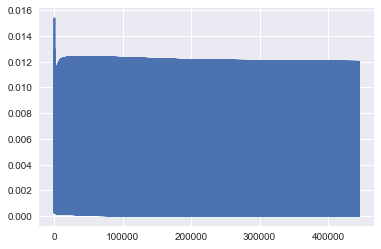

In [78]:
print(len(test_loss))
#plt.plot(test_loss)
plt.plot(train_loss,'-')
#plt.ylim([0.000,0.99])


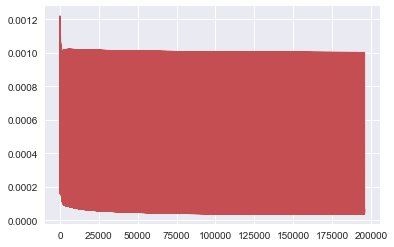

In [79]:
plt.plot(test_loss,'r')

#### Demornamization

In [80]:
rmse = np.sqrt(mse)

In [81]:
rmse_denorm = (rmse * (df_new_test['Kt'].max() - df_new_test['Kt'].min()))+ df_new_test['Kt'].mean()

In [82]:
rmse_denorm

41.210071429887584

In [83]:
df_new_test['Kt'].describe()

count    4436.000000
mean        6.507812
std        78.342619
min        -0.243412
25%        -0.012431
50%        -0.007427
75%         0.755307
max      4900.219009
Name: Kt, dtype: float64

### Saving train and test losses to a csv

In [84]:
df_trainLoss = pd.DataFrame(data={'Train Loss':train_loss}, columns=['Train Loss'])
df_trainLoss.to_csv('RNN Paper Results/Exp1_DesertRock_5000Epoch_TrainLoss.csv')
df_testLoss = pd.DataFrame(data={'Test Loss':test_loss}, columns=['Test Loss'])
df_testLoss.to_csv('RNN Paper Results/Exp1_DesertRock_5000EpochTestLoss.csv')